# [ADA-2020]: P4-milestone
### Group project: Friendship and home position

**Objective**: Inspect the difference in quantity, quality and distribution of friends according to where a person lives

**Authors**: ADA Dream Team

**Study paper**: Eunjoon Cho, Seth A. Myers and Jure Leskovec, *Friendship and Mobility: User Movement in Location-Based Social Network*, Standford University, 2011

**Datasets**:
1. Gowalla dataset: https://snap.stanford.edu/data/loc-gowalla.html. A dataset from the paper. Checkins of users and friends relationship.
2. Brightkite dataset: https://snap.stanford.edu/data/loc-Brightkite.html. A dataset from the paper. Checkins of users and friends relationship.
3. Compilation of UNData: https://www.kaggle.com/sudalairajkumar/undata-country-profiles. Different characteristics for each country.
4. Compilation of USGovt: https://www.kaggle.com/fernandol/countries-of-the-world. More characteristics for each country.
5. happiness2020.pkl and countries_info.csv from "tutorial 01- Handling data", extracted from the World Happiness Report of the United Nations Sustainable Development Solution Network. More characteristics for each country.

**Method**: The method that will be used here is the following:

<span style="color:red">!! ADD WHOLE METHOD (SUMMARY)!!</span>

**Others**: 
The abstract as well as the research questions can be found on the README.md.

In [1]:
#Librairies

#General purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

#Convert country names to ISO codes
import pycountry 
import pycountry_convert 

#Convert longitudes and latitudes to country
import reverse_geocoder 

#Plot country map
import cartopy 
import cartopy.io.shapereader as shpreader
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import shapely.wkt as wkt
from shapely.geometry import MultiPolygon

#Handle colors
import matplotlib.cm as cm
import matplotlib.colors as mcolors

#Library to normalize/standarize values
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

#Statistical tests
from bioinfokit.analys import stat
from scipy import stats

#ML mehtods
from sklearn.mixture import GaussianMixture # clustering
import statsmodels.formula.api as smf       # regression
from pca import pca                         # principal component analysis

In [2]:
#Global constants
PATH = "data/"

## 0. Extraction of the data, preprocessing and merge
In this section, the different dataset will be loaded and preprocessed. Preprocess is the same as the one presented in the tutorial and in our previous milestone. The countries dataset will be merged together to form a big dataset with all the data about each country.

### 0.1 Users dataset
Gowalla and Brightkite are social networks. Their dataset are composed of checkins of each users (place, date, ...) and their friendship relations.

In [3]:
#Extraction parameters
EXTENSION = ".txt.gz"
SEPARATOR = "\t"
CHECKIN_COLUMNS_NAME = ["user", "check-in time", "latitude", "longitude", "location id"]
EDGE_COLUMNS_NAME = ["friend1", "friend2"]
#Extract dataframe from .txt.gz (tabulated separated without header)
user = "ANDRES"
if user == "ANDRES":
    gowalla_edges = pd.read_csv(PATH+"Gowalla_edges.csv", sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    gowalla_checkins = pd.read_csv(PATH+"Gowalla_totalCheckins.csv", sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
    bright_edges = pd.read_csv(PATH+"Brightkite_edges.csv", sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    bright_checkins = pd.read_csv(PATH+"Brightkite_totalCheckins.csv", sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
elif user == "IDS":
    bright_edges = pd.read_csv(PATH+"loc-brightkite_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    bright_checkins = pd.read_csv(PATH+"loc-brightkite_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
    gowalla_edges = pd.read_csv(PATH+"loc-gowalla_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    gowalla_checkins = pd.read_csv(PATH+"loc-gowalla_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
else:
    bright_edges = pd.read_csv(PATH+"loc-brightkite_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    bright_checkins = pd.read_csv(PATH+"loc-brightkite_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)
    gowalla_edges = pd.read_csv(PATH+"loc-gowalla_edges"+EXTENSION, sep=SEPARATOR, header = None, names = EDGE_COLUMNS_NAME)
    gowalla_checkins = pd.read_csv(PATH+"loc-gowalla_totalCheckins"+EXTENSION, sep=SEPARATOR, header = None, names = CHECKIN_COLUMNS_NAME)


#Remove from checkin some invalid points (null data and incoherent latitudes)
bright_0_lat = bright_checkins[bright_checkins["latitude"] == 0]
bright_0_lat_long = bright_0_lat[bright_0_lat["longitude"] == 0]
bright_checkins = bright_checkins.drop(bright_0_lat_long.index)
bright_big_lat = bright_checkins[bright_checkins["latitude"]>90]
bright_checkins = bright_checkins.drop(bright_big_lat.index)
bright_small_lat = bright_checkins[bright_checkins["latitude"]<-90]
bright_checkins = bright_checkins.drop(bright_small_lat.index)

gowalla_0_lat = gowalla_checkins[gowalla_checkins["latitude"] == 0]
gowalla_0_lat_long = gowalla_0_lat[gowalla_0_lat["longitude"] == 0]
gowalla_checkins = gowalla_checkins.drop(gowalla_0_lat_long.index)
gowalla_big_lat = gowalla_checkins[gowalla_checkins["latitude"]>90]
gowalla_checkins = gowalla_checkins.drop(gowalla_big_lat.index)
gowalla_small_lat = gowalla_checkins[gowalla_checkins["latitude"]<-90]
gowalla_checkins = gowalla_checkins.drop(bright_small_lat.index)

#Sample dataframe to analyze and verify structure
#bright_edges.sample(1)
bright_checkins.sample(1)
#gowalla_edges.sample(1)
#gowalla_checkins.sample(1)

,user,check-in time,latitude,longitude,location id
2789232,11626,2010-05-15T20:19:05Z,19.700779,-101.184425,ea3cbb7ca22411dd8a23ff7818d32ef7


We merge BrightKite and Gowalla datasets (but users of one cannot be friend with users of the other).

In [4]:
#Find max ids for brightkite
max_b_checkin_id = bright_checkins.index.max()
max_b_user_id =  bright_checkins.user.max()

#Increment Gowalla ids by max of BrightKite
gowalla_checkins.index = gowalla_checkins.index + (max_b_checkin_id+1)
gowalla_checkins.user = gowalla_checkins.user + (max_b_user_id+1)
gowalla_edges.friend1 = gowalla_edges.friend1 + (max_b_user_id+1)
gowalla_edges.friend2 = gowalla_edges.friend1 + (max_b_user_id+1)

#Concatenate the datasets
edges = pd.concat([bright_edges, gowalla_edges])
checkins = pd.concat([bright_checkins, gowalla_checkins])

### 0.2 Countries dataset
Three different dataset with informations about countries will be used. The first one is from the World Happiness Report of the United Nations Sustainable Development Solution Network, it was presented in the Tutorial of this class; it will be refered as country_WHR (for World Happiness Report). The second one is a compilation (from https://www.kaggle.com/sudalairajkumar/undata-country-profiles) of data from the UN (http://data.un.org/); it will refered as country_UN. The last one is also a compilation (https://www.kaggle.com/fernandol/countries-of-the-world) of data from the CIA (https://www.cia.gov/library/publications/the-world-factbook/); it will be refered as country_CIA.

First, we load and preprocess each one. Then we merge all their information into a big dataset; countries_features.

#### 0.2.1  World Happiness Report (WHR)

In [5]:
#Load data
countries = pd.read_csv(PATH+"countries_info.csv")
happiness = pd.read_csv(PATH+"happiness2020.csv")

#Lower case countries from happiness so merge will be possible
happiness["country"] = happiness["country"].str.lower()
#Change column name so they will merge (not duplicated) #!may exist a simpler alternative in the merge options
names = countries.columns.tolist()
names[names.index("country_name")] = "country"
countries.columns = names
#Merge
country_WHR = pd.merge(happiness, countries, left_on = "country", right_on = "country")

#Drop the columns if there is an invalid data (we won't be able to use feature if not all country have it)
country_WHR = country_WHR.dropna(axis = 1)

#Restore first letter as upper case for latter use
country_WHR.country = country_WHR.country.str.title()

#Sample dataframe to analyze and verify structure
country_WHR.sample(1)

,country,happiness_score,social_support,healthy_life_expectancy,freedom_of_choices,generosity,perception_of_corruption,world_region,area,population
133,Zambia,3.7594,0.698824,55.299377,0.8065,0.078037,0.80129,Sub-Saharan Africa,752614,11502010


#### 0.2.2  United Nation Compilation (UN)

In [6]:
#Converts the ratio string ("x/y") to the corresponding float
def string_div_to_float(my_string):
    try:
        num, denom = my_string.split('/')
        return float(num) / float(denom)
    except ValueError: #some of the data have ".../..." as a ratio...
        return -100

In [7]:
#Load data (Some datasets represents ratio as such strings "x/y", we will convert it with a float resulting of the division)
country_UN = pd.read_csv(PATH+"country_profile_variables.csv", converters={"Labour force participation (female/male pop. %)":string_div_to_float, "Life expectancy at birth (females/males, years)":string_div_to_float,"Education: Primary gross enrol. ratio (f/m per 100 pop.)":string_div_to_float, "Education: Tertiary gross enrol. ratio (f/m per 100 pop.)":string_div_to_float,"Population age distribution (0-14 / 60+ years, %)":string_div_to_float, "Forested area (% of land area)":string_div_to_float,"Education: Secondary gross enrol. ratio (f/m per 100 pop.)":string_div_to_float,"International migrant stock (000/% of total pop.)":string_div_to_float,"Energy supply per capita (Gigajoules)":string_div_to_float,"Pop. using improved drinking water (urban/rural, %)":string_div_to_float})

#Treat some aberrations
country_UN = country_UN.replace("~0.0",0)
country_UN = country_UN.replace("...",np.nan)

#Drop the columns if there is an invalid data (we won't be able to use feature if not all country have it)
country_UN = country_UN.dropna(axis = 1)

#Remove Guadeloupe and Mayotte that are french
country_UN = country_UN[country_UN.country != "Guadeloupe"]
country_UN = country_UN[country_UN.country != "Mayotte"]

#Sample dataframe to analyze and verify structure
country_UN.sample(1)

,country,Region,Surface area (km2),Population in thousands (2017),"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",GDP per capita (current US$),Economy: Agriculture (% of GVA),...,Education: Tertiary gross enrol. ratio (f/m per 100 pop.),Seats held by women in national parliaments %,Individuals using the Internet (per 100 inhabitants),Threatened species (number),Forested area (% of land area),CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy supply per capita (Gigajoules),"Pop. using improved drinking water (urban/rural, %)",Net Official Development Assist. received (% of GNI)
196,Sweden,NorthernEurope,438574,9911,24.2,100.2,495694,4.1,50687.5,1.3,...,1.52621,43.6,54,68.9,9.644444,1428,206,1.0,0.995984,-99


#### 0.2.3  Central Intelligence Agency Compilation (CIA)

In [8]:
#Load data
country_CIA = pd.read_csv(PATH+"countries of the world.csv")

#Same country index name
country_CIA = country_CIA.rename(columns = {"Country":"country"})

#Change commas with dot
country_CIA = country_CIA.stack().str.replace(',','.').unstack()

#Remove Guadeloupe and Mayotte that are french and Virgin Islands that are american
country_CIA = country_CIA[country_CIA.country != "Guadeloupe "]
country_CIA = country_CIA[country_CIA.country != "Mayotte "]
country_CIA = country_CIA[country_CIA.country != "Virgin Islands "]

#Drop the columns if there is an invalid data (we won't be able to use feature if not all country have it)
country_CIA = country_CIA.dropna(axis = 1)

#Sample dataframe to analyze and verify structure
country_CIA.sample(1)

,country,Region,Pop. Density (per sq. mi.),Coastline (coast/area ratio)
153,N. Mariana Islands,OCEANIA,172.9,310.69


#### 0.2.4 Merge the three datasets
The three datasets will be merged in this section. To be able to merge them we need a common identifier, to do so we use the pycountry library. We did not found a library able to work with pandas so we have to do a lambda iteration, which is reasonable as the number of countries is not incredeibly large and we only do it once. 

Note that the WHR dataset is smaller than the two others. Also note that during this conversion some countries are not correctly identified and so are removed, however these countries are in most cases small islands or countries in development which may have very little nor no data for the networks dataset.

In [9]:
#from https://codereview.stackexchange.com/questions/238714/basic-function-to-convert-country-name-to-iso-code-using-pycountry
# convert country name in alpha 3 name
def country_to_alpha3(country):
    try:
        result = pycountry.countries.search_fuzzy(country)
    except Exception:
        return np.nan
    else:
        return result[0].alpha_3

#Convert the name of a country to alpha 2 code
def country_to_alpha2(country):
    try:
        result = pycountry_convert.country_name_to_country_alpha2(country)
    except Exception:
        result = np.nan
    return result

In [10]:
#Create a table to convert country - alpha 3 and alpha 2 : ALPHA3 will be used as much as possible
countries_names = country_UN.country.unique()
countries_alpha2 = np.array([country_to_alpha2(country) for country in countries_names])
countries_alpha3 = np.array([country_to_alpha3(country) for country in countries_names])

#Group them
country_translator = pd.DataFrame(data = {"country":countries_names,"alpha2":countries_alpha2,"alpha3":countries_alpha3})

#Send Nigeria and Niger to invalid country because they have the same alpha3 (same for worst and best Korea)
country_translator = country_translator[country_translator.alpha3 != "PRK"]
country_translator = country_translator[country_translator.alpha3 != "NGA"]

#Drop a country if it has no code associated
country_translator = country_translator.replace("nan",np.nan).dropna()

#Example
country_translator.sample(1)

,country,alpha2,alpha3
61,Ecuador,EC,ECU


In [11]:
#Change country names to alpha3 so they can be compared  (we cannot use the table because names maybe differents)
country_WHR['alpha3'] = country_WHR.country.apply(lambda name: country_to_alpha3(name))
country_UN['alpha3'] = country_UN.country.apply(lambda name: country_to_alpha3(name))
country_CIA['alpha3'] = country_CIA.country.apply(lambda name: country_to_alpha3(name))

#Remove the countries that received invalid alpha3 number
country_WHR = country_WHR.dropna()
country_UN = country_UN.dropna()
country_CIA = country_CIA.dropna()
#Nigeria and Niger have the same alpha3 code
country_WHR = country_WHR[country_WHR.alpha3 != "NGA"] 
country_UN = country_UN[country_UN.alpha3 != "NGA"]
country_CIA = country_CIA[country_CIA.alpha3 != "NGA"]
#Same for best and worst Korea
country_WHR = country_WHR[country_WHR.alpha3 != "PRK"] 
country_UN = country_UN[country_UN.alpha3 != "PRK"]
country_CIA = country_CIA[country_CIA.alpha3 != "PRK"]
#Remove the information repeated accross datasets
TO_REMOVE_WHR = ["healthy_life_expectancy", "world_region", "area", "population","country"]
TO_REMOVE_CIA = ["Region","country","Pop. Density (per sq. mi.)"]
TO_REMOVE_UN = ["country"]
country_WHR = country_WHR.drop(columns = TO_REMOVE_WHR)
country_CIA = country_CIA.drop(columns = TO_REMOVE_CIA)
country_UN = country_UN.drop(columns = TO_REMOVE_UN)

In [12]:
#Merge the different datasets
countries_features = country_WHR.merge(country_UN, left_on = "alpha3", right_on = "alpha3", how="inner")
countries_features = countries_features.merge(country_CIA, left_on = "alpha3", right_on = "alpha3", how="inner")

countries_features.rename(columns = {
 'Population density (per km2, 2017)' : "Population_density",
 'Sex ratio (m per 100 f, 2017)' : 'Sex_ratio',
 'GDP growth rate (annual %, const. 2005 prices)' : 'GPD_growth_rate',
 'GDP per capita (current US$)' : 'GDP_per_capita',
 'Labour force participation (female/male pop. %)': 'Labour_force_participation',
 'Population growth rate (average annual %)' : 'Population_growth_rate',
 'Urban population (% of total population)' : 'Urban_population',
 'Urban population growth rate (average annual %)' : 'Urban_population_growth_rate',
 'Life expectancy at birth (females/males, years)' : 'Life_expectancy_at_birth',
 'Population age distribution (0-14 / 60+ years, %)' : 'Population_age_distribution',
 'International migrant stock (000/% of total pop.)' : 'International_migrant_stock',
 'Health: Total expenditure (% of GDP)' : 'Heath_total_expenditure',
 'Education: Primary gross enrol. ratio (f/m per 100 pop.)' : 'Education_Primary',
 'Education: Secondary gross enrol. ratio (f/m per 100 pop.)' : 'Education_Secondary',
 'Education: Tertiary gross enrol. ratio (f/m per 100 pop.)' : 'Education_Tertiary',
 'Individuals using the Internet (per 100 inhabitants)' : 'Individuals_using_the_Internet',
 'Forested area (% of land area)' : 'Forested_area',
 'Energy supply per capita (Gigajoules)' : 'Energy_supply_per_capita',
 'Coastline (coast/area ratio)' : 'Coastline'}, inplace = True)

#Sample dataframe to analyze and verify structure
countries_features.sample(4)

,happiness_score,social_support,freedom_of_choices,generosity,perception_of_corruption,alpha3,Region,Surface area (km2),Population in thousands (2017),Population_density,...,Seats held by women in national parliaments %,Individuals_using_the_Internet,Threatened species (number),Forested_area,CO2 emission estimates (million tons/tons per capita),"Energy production, primary (Petajoules)",Energy_supply_per_capita,"Pop. using improved drinking water (urban/rural, %)",Net Official Development Assist. received (% of GNI),Coastline
73,4.7293,0.731469,0.711566,-0.044367,0.839328,MLI,WesternAfrica,1240192,18542,15.2,...,8.8,42,3.9,14.000000,55,4,1.505460,2.329193,-99,0.00
6,7.2942,0.928046,0.899989,0.085429,0.499955,AUT,WesternEurope,83871,8736,106.0,...,30.6,118,46.9,8.507246,505,158,1.000000,1.000000,-99,0.00
37,7.8087,0.954330,0.949172,-0.059482,0.195445,FIN,NorthernEurope,338440,5523,18.2,...,42.0,36,73.1,5.500000,757,257,1.000000,1.129545,-99,0.37
125,3.7594,0.698824,0.806500,0.078037,0.801290,ZMB,EasternAfrica,752612,17094,23.0,...,18.0,88,65.6,15.000000,374,26,1.668616,1.557423,-99,0.00


From all the features we remove the ones that we consider uninteresting for our application or repeated in different ways (density of population and total population).

In [13]:
TO_REMOVE = ["Surface area (km2)","GDP: Gross domestic product (million current US$)", "Economy: Agriculture (% of GVA)","Economy: Industry (% of GVA)", "Economy: Services and other activity (% of GVA)","Agricultural production index (2004-2006=100)","Food production index (2004-2006=100)","Seats held by women in national parliaments %","Threatened species (number)","CO2 emission estimates (million tons/tons per capita)","Energy production, primary (Petajoules)","Pop. using improved drinking water (urban/rural, %)","Net Official Development Assist. received (% of GNI)"]
countries_features = countries_features.drop(columns=TO_REMOVE)

In the end, we have a dataset with 127 countries (there was 131 valid countries in the WHR dataset). In total there is 26 columns. So there is 25 features for each country, they are:

In [14]:
features_global = countries_features.columns
for feature in features_global:
    if(feature != "country" and feature != "alpha3_name"):
        print(feature)

happiness_score
social_support
freedom_of_choices
generosity
perception_of_corruption
alpha3
Region
Population in thousands (2017)
Population_density
Sex_ratio
GPD_growth_rate
GDP_per_capita
Labour_force_participation
Population_growth_rate
Urban_population
Urban_population_growth_rate
Life_expectancy_at_birth
Population_age_distribution
International_migrant_stock
Heath_total_expenditure
Education_Primary
Education_Secondary
Education_Tertiary
Individuals_using_the_Internet
Forested_area
Energy_supply_per_capita
Coastline


The country in our dataset are represented above (code copied by https://github.com/SciTools/cartopy/issues/1303 and exception error by https://stackoverflow.com/questions/63943614/python-cartopy-how-to-solve-polygon-object-error):

In [15]:
#Color a counter (indicated by its ISO code) in a color
def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                                  alpha = 1.00, linewidth =0.15, edgecolor = "black",
                                  label=n.attributes['ADM0_A3']) 
            except Exception as e:
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr, 
                                  alpha = 1.00, linewidth =0.15, edgecolor = "black",
                                  label=n.attributes['ADM0_A3']) 
            return ax

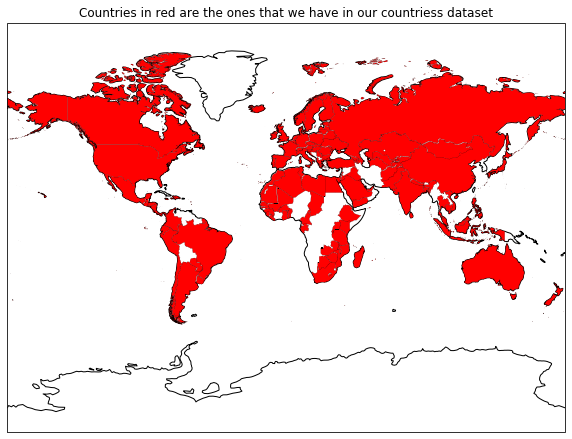

In [16]:
#Plot the countries that are in our dataset (!takes some time)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

for n in countries_features.alpha3 :
    area(ax, n, "red")
    
plt.title("Countries in red are the ones that we have in our countriess dataset")
plt.show()

## 1. Compute home position
Average the home position of the users. This is done like explained in the paper. The implementation is exactly the same as what was done for P2-milestone and so here we just load the result. The jupyter notebook that explain this can be found in the git under the name "replication_report".

In [17]:
#Load the home position
bright_home_pos_light = pd.read_csv(PATH+"b_home.csv").set_index("user")
gowalla_home_pos_light = pd.read_csv(PATH+"g_home.csv").set_index("user")

#Merge the two homes datasaets
gowalla_home_pos_light.index = gowalla_home_pos_light.index + (max_b_user_id+1)
home_pos = pd.concat([bright_home_pos_light, gowalla_home_pos_light])

## 2. Compute nationality and remove non used countries

### 2.1 Compute nationality of the users
Convert longitude latitude to country. To do so we use the reverse_geocoder library.

In [18]:
home_pos = home_pos.reset_index()

In [19]:
#Convert long-lat peer in tupple so it is easier for the library
longlat_tupple = list(zip(home_pos.lat, home_pos.long))

#Search the localisation of each datapoint
home_pos_tmp = home_pos.copy()
home_pos_tmp["loc"] = reverse_geocoder.search(longlat_tupple)
home_pos_tmp = home_pos_tmp.set_index("user")

#Separate the localisation information in the different part (name of the city, admin district, country code)
home_pos_tmp = pd.DataFrame(home_pos_tmp['loc'].to_list(), index=home_pos_tmp.index)

#Convert country code to country name
home_pos_tmp = home_pos_tmp.reset_index()
home_pos_tmp = home_pos_tmp.merge(country_translator, left_on = "cc", right_on = "alpha2")
home_pos_tmp = home_pos_tmp.set_index("user")

#Remove if a country is not represented by an alpha3 value
print(home_pos_tmp)
home_pos_tmp = home_pos_tmp.dropna()
print(home_pos_tmp)

#Remove the useless columns
TO_REMOVE = ["name","admin1","admin2","lat","lon", "cc", "country", "alpha2"]
nat = home_pos_tmp.drop(columns = TO_REMOVE)

#An other dataset with also the position of the home
TO_REMOVE = ["name","admin1","admin2", "cc", "country", "alpha2"]
home_pos = home_pos_tmp.drop(columns = TO_REMOVE)

#Sample dataframe to analyze and verify structure
#nat.sample(4)
home_pos.sample(4)

Loading formatted geocoded file...
             lat         lon            name            admin1  \
user                                                             
0       39.73915   -104.9847          Denver          Colorado   
1        37.5841  -122.36608      Burlingame        California   
2       39.73915   -104.9847          Denver          Colorado   
3       37.77493  -122.41942   San Francisco        California   
5       37.77493  -122.41942   San Francisco        California   
...          ...         ...             ...               ...   
152089    0.3475    32.64917          Kireka    Central Region   
161676  43.25654    76.92848          Almaty     Almaty Qalasy   
163447  43.94193    12.44738  Borgo Maggiore    Borgo Maggiore   
214135   41.3275    19.81889          Tirana            Tirane   
221945  -9.44314   147.17972    Port Moresby  National Capital   

                      admin2  cc                   country alpha2 alpha3  
user                           

,lat,lon,alpha3
user,,,
4281,33.1579,-96.63166,USA
204595,62.39129,17.3063,SWE
14486,32.84727,-117.2742,USA
106340,34.1064,-117.59311,USA


In [20]:
nat

,alpha3
user,
0,USA
1,USA
2,USA
3,USA
5,USA
...,...
152089,UGA
161676,KAZ
163447,SMR


### 2.2 Find less used countries and remove them
To decide whatever we keep or not a country we compute its users density (sum of the two applications). 

The minimum density is set to 1 person over 100'000 in one country that have th application. It may seem very few, however the dataset has very low density for all countries (see plot and description above, only green are availible with our density) and we need to have at least some countries to compare.

<span style="color:red">DISCUSS THIS CHOICE</span> 

In [21]:
#Count the users of each country
countries_count = nat.alpha3.value_counts()

In [22]:
#Do a safety guard
countries_features_temp = countries_features

#Add the number of users to the countries features and remove
countries_features_temp = countries_features_temp.merge(countries_count, left_on = "alpha3", right_index = True, how = "left")
countries_features_temp = countries_features_temp.rename(columns = {"alpha3_x":"alpha3"})
countries_features_temp = countries_features_temp.rename(columns = {"alpha3_y":"users"})
#Replace the NaN values to 0
countries_features_temp = countries_features_temp.fillna(0)

#Compute the density of users in the population
countries_features_temp["density_users"] = countries_features_temp["users"]/(countries_features_temp["Population in thousands (2017)"]*1000)

In [23]:
countries_features_temp

,happiness_score,social_support,freedom_of_choices,generosity,perception_of_corruption,alpha3,Region,Population in thousands (2017),Population_density,Sex_ratio,...,Heath_total_expenditure,Education_Primary,Education_Secondary,Education_Tertiary,Individuals_using_the_Internet,Forested_area,Energy_supply_per_capita,Coastline,users,density_users
0,2.5669,0.470367,0.396573,-0.096429,0.933687,AFG,SouthernAsia,35530,54.4,106.3,...,8.2,0.692249,0.561528,0.278195,42,32.666667,1.663830,0.00,3.0,8.443569e-08
1,4.8827,0.671070,0.781994,-0.042309,0.896304,ALB,SouthernEurope,2930,106.9,101.9,...,5.9,0.967100,0.936235,1.398357,130,2.850000,0.996849,1.26,1.0,3.412969e-07
2,5.0051,0.803385,0.466611,-0.121105,0.735485,DZA,NorthernAfrica,41318,17.3,102.0,...,7.2,0.943096,1.036697,1.560554,135,39.297297,1.030562,0.04,8.0,1.936202e-07
3,5.9747,0.900568,0.831132,-0.194914,0.842010,ARG,SouthAmerica,44271,16.2,95.9,...,4.8,0.996370,1.066731,1.620472,256,43.404255,0.990000,0.18,117.0,2.642814e-06
4,4.6768,0.757479,0.712018,-0.138780,0.773545,ARM,WesternAsia,2930,102.9,88.8,...,4.5,1.000000,1.010216,1.127404,114,3.055556,1.000000,0.00,0.0,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,6.2576,0.926596,0.974998,0.248427,0.501497,UZB,CentralAsia,31911,75.0,99.4,...,5.8,0.977273,0.982438,0.645455,59,29.222222,1.217553,0.00,3.0,9.401147e-08
123,5.3535,0.849987,0.939593,-0.094533,0.796421,VNM,South-easternAsia,95541,308.1,98.0,...,7.1,0.991766,-100.000000,1.003472,616,92.722222,1.022704,1.05,113.0,1.182738e-06
124,3.5274,0.817981,0.599920,-0.157735,0.800288,YEM,WesternAsia,28250,53.5,102.1,...,5.6,0.841060,0.688153,0.445255,298,25.222222,1.548387,0.36,0.0,0.000000e+00
125,3.7594,0.698824,0.806500,0.078037,0.801290,ZMB,EasternAfrica,17094,23.0,98.5,...,5.0,1.006776,-100.000000,0.755556,88,15.000000,1.668616,0.00,3.0,1.755002e-07


count      127.000000
mean      1220.818898
std       7451.110131
min          0.000000
25%          3.000000
50%         19.000000
75%        256.500000
max      81446.000000
Name: users, dtype: float64


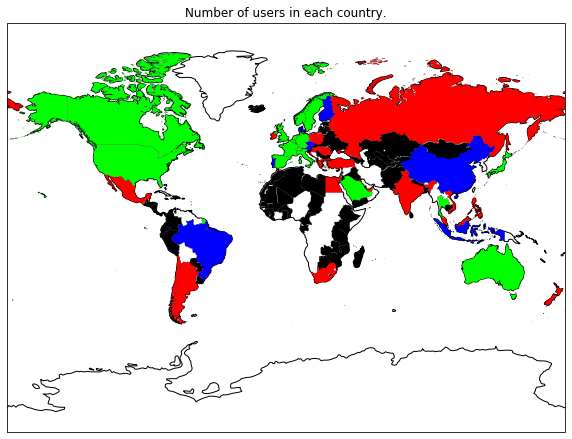

In [24]:
# Plot the number of users distribution
temp = countries_features_temp.copy()

#Plot the countries that are in our dataset (!takes some time)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

for index, t in temp.iterrows() :
    color = (0,0,0)
    if(t.users > 1000):
        color = (0,1,0)
    elif(t.users > 500):
        color = (0,0,1)
    elif(t.users > 100):
        color = (1,0,0)
    area(ax, t.alpha3, color)
    
plt.title("Number of users in each country.")
print(temp.users.describe())

In [25]:
#Remove the countries that have less than 100 users (incoherent results even if enough density)
countries_features_temp = countries_features_temp[countries_features_temp.users > 100]

count    4.700000e+01
mean     1.107020e-04
std      2.958908e-04
min      2.792754e-07
25%      5.348669e-06
50%      2.587041e-05
75%      9.525332e-05
max      1.892947e-03
Name: density_users, dtype: float64


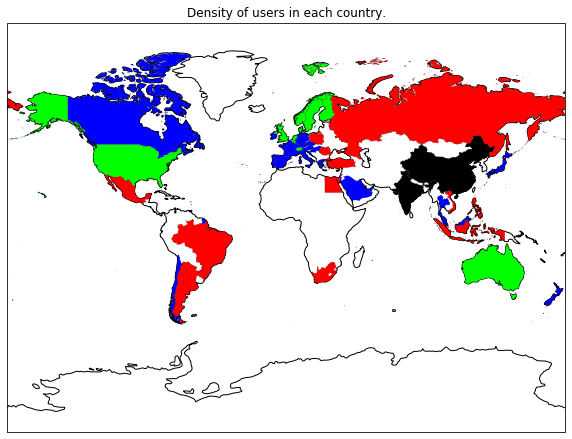

In [26]:
# Plot the density distribution (add Alpha 3 just for the plot)
temp = countries_features_temp.copy()

#Plot the countries that are in our dataset (!takes some time)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

for index, t in temp.iterrows() :
    color = (0,0,0)
    if(t.density_users > 1e-4):
        color = (0,1,0)
    elif(t.density_users > 1e-5):
        color = (0,0,1)
    elif(t.density_users > 1e-6):
        color = (1,0,0)
    area(ax, t.alpha3, color)
    
plt.title("Density of users in each country.")
print(temp.density_users.describe())

In [27]:
#Parameter
MIN_DENSITY = 1e-5

#keep only the countries that have a minimum density of users
countries_features_clean = countries_features_temp[countries_features_temp["density_users"] > MIN_DENSITY]
valid_countries_alpha3 = countries_features_clean.alpha3.values

#Remove the useless columns
TO_REMOVE = ["users","density_users","Population in thousands (2017)"]
countries_features_clean = countries_features_clean.drop(columns = TO_REMOVE)

#Sample dataframe to analyze and verify structure
countries_features_clean.sample(4)

,happiness_score,social_support,freedom_of_choices,generosity,perception_of_corruption,alpha3,Region,Population_density,Sex_ratio,GPD_growth_rate,...,Population_age_distribution,International_migrant_stock,Heath_total_expenditure,Education_Primary,Education_Secondary,Education_Tertiary,Individuals_using_the_Internet,Forested_area,Energy_supply_per_capita,Coastline
111,5.9988,0.889973,0.905063,0.268685,0.886272,THA,South-easternAsia,135.1,95.2,2.8,...,1.023669,674.706897,4.1,0.934967,0.944947,1.414815,611,67.276596,0.995918,0.63
69,7.2375,0.906912,0.905636,-0.004621,0.367084,LUX,WesternEurope,225.3,101.0,3.5,...,0.836735,5.665909,6.9,1.004128,1.023739,1.137363,11,0.560694,1.000000,0.00
43,5.5150,0.814380,0.541345,-0.300907,0.859931,GRC,SouthernEurope,86.6,96.9,-0.2,...,0.535849,109.955752,8.1,0.989806,0.944292,0.997368,374,11.032787,1.000000,10.37
38,6.6638,0.937104,0.825468,-0.130642,0.583521,FRA,WesternEurope,118.7,96.7,1.3,...,0.704280,643.338843,11.5,0.993377,1.009991,1.226252,278,64.531915,1.000000,0.63


In [28]:
#Create a min max version of the dataset (useful for plots)
scaler = MinMaxScaler()
countries_features_0_1 = countries_features_clean.copy()

for column in countries_features_0_1.columns:
    if column != "alpha3" and column != "Region":
        countries_features_0_1[column] = scaler.fit_transform((countries_features_0_1[column].values).reshape(-1,1))


#Create a standarize version of the dataset (useful for ML)
scaler = preprocessing.StandardScaler()
countries_features_std = countries_features_clean.copy()
for column in countries_features_std.columns:
    if column != "alpha3"  and column != "Region":
        countries_features_std[column] = scaler.fit_transform((countries_features_std[column].values).reshape(-1,1))

There are 47 countries available.


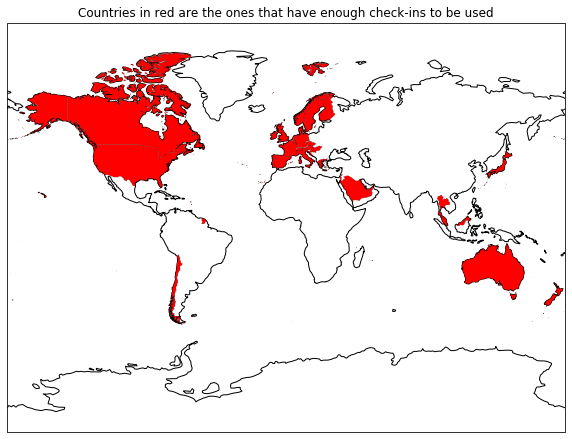

In [29]:
# Plot the countries in the final dataset (add Alpha 3 just for the plot)
temp = countries_features_clean

#Plot the countries that are in our dataset (!takes some time)
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

for n in temp.alpha3 :
    area(ax, n, "red")
    
plt.title("Countries in red are the ones that have enough check-ins to be used")
print("There are "+str(countries_features_temp.shape[0])+" countries available.")
plt.show()

The final number of country is low, but we have to have meaningful results.

### 2.3 Cluster the countries
Try to find if some groups emerge from the countries' features. First data will be normalized (with a StandrardScaler), then we will use k-means with a set of k-values to find the optimal number of clusters. Finally, we show the emerging clusters.

In [30]:
#Generate a list of colors for the plots
colors = mcolors.BASE_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))), name) for name, color in colors.items())
color_names = [name for hsv, name in by_hsv]
color_names.remove("w") #pop white
color_names.extend(["gray","brown","orange","lightgreen","cyan","beige","pink","navy","tan","lime","royalblue","brown","moccasin","deeppink","magenta","slategrey","dodgerblue","oldlace"])
NB_MAX_GRP = len(color_names)

In [31]:
#Save the indetificators that we need
countires_codes = countries_features_std.alpha3

#Remove the information that can not be used for clustering
TO_REMOVE = ["alpha3","Region"]
country_clustering = countries_features_std.drop(columns=TO_REMOVE)

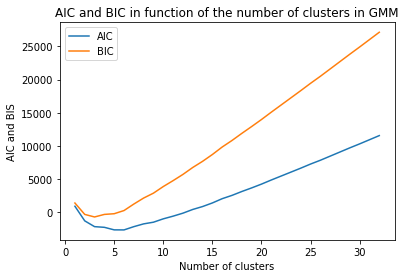

In [32]:
#Initialize the variables
all_aic = []
all_bic = []
NB_MAX_CENTROIDS = len(countires_codes)

#Evaluate the root mean square (RMS) with different values of k
for nb_centroids in range(1, NB_MAX_CENTROIDS):
    gmm = GaussianMixture(n_components=nb_centroids, n_init = 50, init_params = "kmeans").fit(country_clustering)
    all_aic.append(gmm.aic(country_clustering))
    all_bic.append(gmm.bic(country_clustering))
    
    
#Plot the result
plt.plot(np.arange(1,NB_MAX_CENTROIDS), all_aic, label = "AIC")
plt.plot(np.arange(1,NB_MAX_CENTROIDS), all_bic, label = "BIC")
plt.title("AIC and BIC in function of the number of clusters in GMM")
plt.xlabel("Number of clusters")
plt.ylabel("AIC and BIS")
plt.legend()

From the plot we see that the minimum for both occurs around 3 clusters.

In [33]:
#Compute with our best resut
BEST_NB_CLUSTERS = 3
gmm = GaussianMixture(n_components=BEST_NB_CLUSTERS, n_init = 100, init_params = "kmeans").fit(country_clustering)
labels = gmm.fit_predict(country_clustering)
res = pd.DataFrame(index = countires_codes, data = labels, columns =["labels"])

In [34]:
#Print the countries in each cluster
for lab in np.unique(labels):
    print("Label n°"+str(lab))
    print(res[res.labels == lab].index.values)

features_clusters = res

Label n°0
['KWT' 'SAU' 'SGP' 'ARE']
Label n°1
['CHL' 'HRV' 'CZE' 'FRA' 'GRC' 'HUN' 'ITA' 'JPN' 'MYS' 'PRT' 'ESP' 'THA'
 'USA']
Label n°2
['AUS' 'AUT' 'BEL' 'CAN' 'DNK' 'FIN' 'DEU' 'IRL' 'ISR' 'LUX' 'NLD' 'NZL'
 'NOR' 'SWE' 'CHE' 'GBR']


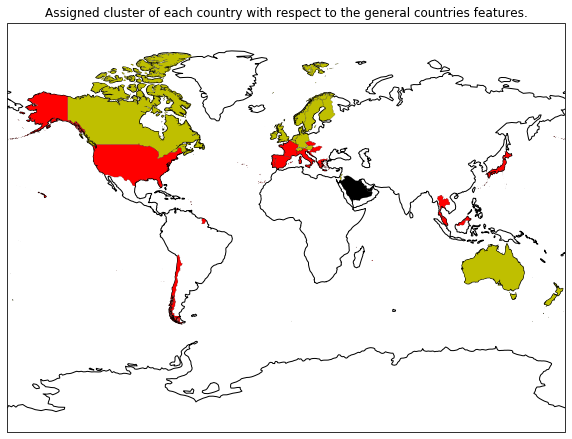

In [35]:
#Create the world for the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

#Extract the clusters
clusters = np.unique(labels)
nb_cluster = np.max(clusters)

#Plot
if(nb_cluster > NB_MAX_GRP): #Some clusters cannot be plotted
    print("COLORS ARE REPEATING")
else:
    for i in range(0, len(labels)) :
        label = labels[i]
        color = color_names[label]
        area(ax, countires_codes.iloc[i], color)

    plt.title("Assigned cluster of each country with respect to the general countries features.")

## 3. Friends charachteristics

### 3.1 Compute Quantitative Charactistics


In [94]:
nat

,alpha3
user,
0,USA
1,USA
2,USA
3,USA
5,USA
...,...
152089,UGA
161676,KAZ
163447,SMR


In [112]:
# Adding to the datasets the nationality of each friend
quant_f = edges.copy()
quant_f = quant_f.merge(nat, left_on="friend1", right_index =True, how = "right").rename(columns = {"alpha3":"alpha3_1"})
quant_f = quant_f.merge(nat, left_on="friend2", right_index =True, how = "right").rename(columns = {"alpha3":"alpha3_2"})

#Example
quant_f

,friend1,friend2,alpha3_1,alpha3_2
0.0,0.0,1,USA,USA
244.0,3.0,1,USA,USA
503.0,4.0,1,FIN,USA
530.0,5.0,1,USA,USA
648.0,7.0,1,USA,USA
...,...,...,...,...
NaN,NaN,85617,NaN,MCO
NaN,NaN,181731,NaN,MCO
NaN,NaN,106914,NaN,CYM
NaN,NaN,147762,NaN,SPM


In [113]:
quant_f.friend1.unique()

array([0.00000e+00, 3.00000e+00, 4.00000e+00, ..., 1.96578e+05,
       1.96585e+05,         nan])

In [114]:
quant_f = quant_f.merge(home_pos, left_on="friend1", right_index =True).rename(columns = {"lat":"friend1_lat","lon":"friend1_lon","alpha3":"friend1_alpha3"})
quant_f = quant_f.merge(home_pos, left_on="friend2", right_index =True).rename(columns = {"lat":"friend2_lat","lon":"friend2_lon","alpha3":"friend2_alpha3"})
quant_f.sample(4)

,friend1,friend2,alpha3_1,alpha3_2,friend1_lat,friend1_lon,friend1_alpha3,friend2_lat,friend2_lon,friend2_alpha3
290511.0,16430.0,46217,USA,USA,39.96097,-75.60804,USA,40.79339,-77.86,USA
581188.0,69198.0,127426,SWE,DEU,59.33258,18.0649,SWE,48.13743,11.57549,DEU
1220392.0,113739.0,171967,USA,GBR,34.00071,-81.03481,USA,51.24827,-0.76389,GBR
29884.0,360.0,1168,USA,USA,34.07808,-118.26066,USA,39.92054,-105.08665,USA


In [115]:
quant_f

,friend1,friend2,alpha3_1,alpha3_2,friend1_lat,friend1_lon,friend1_alpha3,friend2_lat,friend2_lon,friend2_alpha3
0.0,0.0,1,USA,USA,39.73915,-104.9847,USA,37.5841,-122.36608,USA
244.0,3.0,1,USA,USA,37.77493,-122.41942,USA,37.5841,-122.36608,USA
503.0,4.0,1,FIN,USA,60.16952,24.93545,FIN,37.5841,-122.36608,USA
530.0,5.0,1,USA,USA,37.77493,-122.41942,USA,37.5841,-122.36608,USA
648.0,7.0,1,USA,USA,37.5841,-122.36608,USA,37.5841,-122.36608,USA
...,...,...,...,...,...,...,...,...,...,...
1740034.0,196578.0,254806,USA,GBR,34.1064,-117.59311,USA,51.75369,-0.47517,GBR
1740035.0,196578.0,254806,USA,GBR,34.1064,-117.59311,USA,51.75369,-0.47517,GBR
1740036.0,196578.0,254806,USA,GBR,34.1064,-117.59311,USA,51.75369,-0.47517,GBR
1740037.0,196578.0,254806,USA,GBR,34.1064,-117.59311,USA,51.75369,-0.47517,GBR


In [116]:
#Compute the distance btw the home of the users

# approximate radius of earth in km
R = 6373.0

# Converting grades to radians
quant_f["friend1_lat"] = np.radians(quant_f["friend1_lat"].astype(float))
quant_f["friend2_lat"] = np.radians(quant_f["friend2_lat"].astype(float))
quant_f["friend1_lon"] = np.radians(quant_f["friend1_lon"].astype(float))
quant_f["friend2_lon"] = np.radians(quant_f["friend2_lon"].astype(float))

# Calculating the difference between latitudes and longitudes
quant_f["lat_dis"] = quant_f["friend2_lat"]-quant_f["friend1_lat"]
quant_f["lon_dis"] = quant_f["friend2_lon"]-quant_f["friend1_lon"]

# Haversine method to compute the distance
quant_f["a"] = np.sin(quant_f["lat_dis"] / 2)**2 + np.cos(quant_f["friend1_lat"]) * np.cos(quant_f["friend2_lat"]) * np.sin(quant_f["lon_dis"] / 2)**2
quant_f["c"] = 2 * np.arctan2(np.sqrt(quant_f["a"]), np.sqrt(1 - quant_f["a"]))

quant_f["distance"] = R * quant_f["c"]

In [131]:
threshold = 50 #km between users

# Creating a new data set with friendship info for each user
# Number of friends
friends_ch_q = pd.DataFrame(quant_f.groupby("friend1")["friend2"].count()).rename(columns={"friend2":"n_friends"})
# Number of friends in the same country
friends_ch_q["n_friends_same_country"] = quant_f[quant_f.alpha3_1 == quant_f.alpha3_2].groupby("friend1")["friend2"].count()
# Ratio of friends in the same country
friends_ch_q["ratio_friends_same_country"] = friends_ch_q["n_friends_same_country"]/friends_ch_q["n_friends"]
# Number of friends within a distance
friends_ch_q["n_friends_near"] = quant_f[quant_f.distance < threshold].groupby("friend1")["friend2"].count()
# Ratio of friends within a distance
friends_ch_q["ratio_friends_near"] = friends_ch_q["n_friends_near"]/friends_ch_q["n_friends"]

# Filling Nan values (due to .count() function) with zeros
friends_ch_q = friends_ch_q.fillna(0)

#Example
friends_ch_q

,n_friends,n_friends_same_country,ratio_friends_same_country,n_friends_near,ratio_friends_near
friend1,,,,,
0.0,119,101.0,0.848739,65.0,0.546218
1.0,39,34.0,0.871795,24.0,0.615385
2.0,81,68.0,0.839506,33.0,0.407407
3.0,229,197.0,0.860262,59.0,0.257642
4.0,26,6.0,0.230769,6.0,0.230769
...,...,...,...,...,...
196514.0,2,0.0,0.000000,0.0,0.000000
196520.0,2,0.0,0.000000,0.0,0.000000
196531.0,1,0.0,0.000000,0.0,0.000000


### 3.2 Qualitative friendship charachteristics

In [132]:
#drop useless columns and sort dataframe
gw_qual_checkins = gowalla_checkins.copy()
gw_qual_checkins["check-in time"] = pd.to_datetime(gw_qual_checkins["check-in time"])
gw_qual_times = gw_qual_checkins[["user", "location id", "check-in time"]]
gw_qual_times = gw_qual_times.sort_values(["location id", "check-in time"])

In [133]:
bk_qual_checkins = bright_checkins.copy()
bk_qual_checkins["check-in time"] = pd.to_datetime(bk_qual_checkins["check-in time"])
bk_qual_times = bk_qual_checkins[["user", "location id", "check-in time"]]
bk_qual_times = bk_qual_times.sort_values(["location id", "check-in time"]).dropna()

In [134]:
qual_times = pd.concat([gw_qual_times, bk_qual_times])

In [135]:
#time tolerance to define meeting
TOL = 30 #minutes
tol = datetime.timedelta(minutes=TOL)

#compute time differences
qual_times["time_diff_with_prev"] = qual_times["check-in time"].diff()
qual_times["time_diff_with_next"] = qual_times["time_diff_with_prev"].shift(-1)

#drop check-ins isolated by more than TOL -> Reduces dataset 
bool_prev = (qual_times["time_diff_with_prev"] <= tol) & \
            (qual_times["time_diff_with_prev"] >= datetime.timedelta(minutes=0))
bool_next = (qual_times["time_diff_with_next"] <= tol) & \
            (qual_times["time_diff_with_next"] >= datetime.timedelta(minutes=0))

qual_times_small = qual_times[bool_prev | bool_next ]
qual_times_small = qual_times_small.sort_values(["location id", "user"]) 
qual_times_small = qual_times_small.drop(columns = ["time_diff_with_prev", "time_diff_with_next"])

qual_times_small["year"] = qual_times_small["check-in time"].dt.year
qual_times_small["month"] = qual_times_small["check-in time"].dt.month
qual_times_small["day"] = qual_times_small["check-in time"].dt.day

qual_times_small.sample(3)

,user,location id,check-in time,year,month,day
10733476,209566,49360,2010-04-24 19:26:56+00:00,2010,4,24
907414,2822,b9bf2a66a22411ddb7beff09d85922c2,2009-10-03 21:17:20+00:00,2009,10,3
6840823,76842,671245,2010-03-13 19:52:59+00:00,2010,3,13


In [136]:
#build dataframe with check-ins relation
checkins_relation = qual_times_small.merge(qual_times_small, on = ["location id", "year", "month", "day"])

#remove same user relations
checkins_relation =checkins_relation[checkins_relation["user_x"] != checkins_relation["user_y"]]

#compute time difference between users' checkins
checkins_relation["time_diff"] = abs(checkins_relation["check-in time_x"] - checkins_relation["check-in time_y"])

#filter simulateneous check-ins
checkins_relation = checkins_relation[checkins_relation["time_diff"] <= tol]

checkins_relation.head()

,user_x,location id,check-in time_x,year,month,day,user_y,check-in time_y,time_diff
1,60584,8932,2010-08-02 01:32:38+00:00,2010,8,2,121984,2010-08-02 01:17:30+00:00,00:15:08
2,121984,8932,2010-08-02 01:17:30+00:00,2010,8,2,60584,2010-08-02 01:32:38+00:00,00:15:08
5,58501,8938,2010-04-23 16:57:24+00:00,2010,4,23,58716,2010-04-23 16:58:54+00:00,00:01:30
6,58716,8938,2010-04-23 16:58:54+00:00,2010,4,23,58501,2010-04-23 16:57:24+00:00,00:01:30
9,63121,8938,2009-12-14 00:28:35+00:00,2009,12,14,63392,2009-12-14 00:33:38+00:00,00:05:03


In [137]:
#count number of meetings between users
nb_meetings = checkins_relation.groupby(["user_x", "user_y"]).count()
nb_meetings = nb_meetings[["time_diff"]]
nb_meetings = nb_meetings.rename(columns = {"time_diff": "meetings"})

nb_meetings

meetings
user_x user_y          
0      1              7
       2            229
       3              3
       4              2
       5              1
...                 ...
254700 254097         4
254716 254717         6
254717 188798         1
       254716         6
254789 60602          1

[959060 rows x 1 columns]

In [138]:
edges_tmp = edges.set_index(["friend1", "friend2"])

In [139]:
#infer friendship quality features from meetings:
#gowalla
friend_meetings = edges_tmp.join(nb_meetings, on = ["friend1", "friend2"])
friend_meetings = friend_meetings.fillna(0)

friend_q = friend_meetings.groupby("friend1").max()
friend_q = friend_q.rename(columns = {"meetings":"best_friend_meetings"})
friend_q["average_meetings"] =  friend_meetings.groupby("friend1").mean().meetings

met_friends = friend_meetings[friend_meetings["meetings"] > 0].groupby("friend1").count()
met_friends = met_friends.rename(columns = {"meetings": "met_friends"})

friend_q["met_friends"] = met_friends["met_friends"]

friend_q = friend_q.fillna(0)

friend_q = friend_q[["best_friend_meetings","average_meetings","met_friends"]]

#Example
friend_q

,best_friend_meetings,average_meetings,met_friends
friend1,,,
0,229.0,5.916667,47.0
1,69.0,5.350000,21.0
2,229.0,3.855422,17.0
3,51.0,0.667954,16.0
4,11.0,2.592593,15.0
...,...,...,...
254814,0.0,0.000000,0.0
254815,0.0,0.000000,0.0
254816,0.0,0.000000,0.0


### 3.3 Merge all

#### 3.3.1 Merge quantitative and qualitative

In [140]:
users_all = pd.merge(friend_q, friends_ch_q, left_index = True, right_index = True)
users_all = pd.merge(users_all, nat, left_index = True, right_index = True).dropna()

#add met friends ratio
users_all["met_friends_ratio"] = users_all["met_friends"]/users_all["n_friends"]


users_all

,best_friend_meetings,average_meetings,met_friends,n_friends,n_friends_same_country,ratio_friends_same_country,n_friends_near,ratio_friends_near,alpha3,met_friends_ratio
0,229.0,5.916667,47.0,119,101.0,0.848739,65.0,0.546218,USA,0.394958
1,69.0,5.350000,21.0,39,34.0,0.871795,24.0,0.615385,USA,0.538462
2,229.0,3.855422,17.0,81,68.0,0.839506,33.0,0.407407,USA,0.209877
3,51.0,0.667954,16.0,229,197.0,0.860262,59.0,0.257642,USA,0.069869
4,11.0,2.592593,15.0,26,6.0,0.230769,6.0,0.230769,FIN,0.576923
...,...,...,...,...,...,...,...,...,...,...
196514,0.0,0.000000,0.0,2,0.0,0.000000,0.0,0.000000,USA,0.000000
196520,0.0,0.000000,0.0,2,0.0,0.000000,0.0,0.000000,THA,0.000000
196531,0.0,0.000000,0.0,1,0.0,0.000000,0.0,0.000000,USA,0.000000
196578,0.0,0.000000,0.0,6,0.0,0.000000,0.0,0.000000,USA,0.000000


#### 3.3.2 Apply some modifs

In [50]:
#Groupby country and do the mean of each feature
countries_friendships_ch =  users_all.groupby(["alpha3"]).mean().reset_index()

#Keep only the countries that are in the valid country dataset
countries_friendships_ch = countries_friendships_ch[countries_friendships_ch['alpha3'].isin(valid_countries_alpha3)]

#Remove useless informations
countries_friendships_ch = countries_friendships_ch.drop(columns = ["n_friends_same_country", "n_friends_near"])

#Example
countries_friendships_ch

,alpha3,best_friend_meetings,average_meetings,met_friends,n_friends,ratio_friends_same_country,ratio_friends_near,met_friends_ratio
4,ARE,0.000000,0.000000,0.000000,7.780488,0.166412,0.157266,0.000000
6,AUS,0.668050,0.087562,0.175830,8.949170,0.589125,0.413252,0.026652
7,AUT,0.161094,0.041662,0.072948,12.212766,0.215483,0.166445,0.014632
9,BEL,0.060185,0.013445,0.037037,13.986111,0.245603,0.166688,0.007524
22,CAN,0.279322,0.075071,0.085578,8.370547,0.347908,0.258515,0.025542
23,CHE,0.174312,0.033211,0.055046,13.328440,0.236528,0.172210,0.014317
24,CHL,0.591241,0.083257,0.248175,8.733577,0.726527,0.487655,0.026730
31,CZE,0.012780,0.002293,0.012780,14.792332,0.133963,0.067461,0.002427
32,DEU,0.439936,0.070407,0.110467,11.478261,0.365704,0.185482,0.020194
33,DNK,1.073446,0.201327,0.115819,7.330508,0.409362,0.351477,0.029325


In [51]:
#Create a min max version of the dataset (useful for plots)
scaler = MinMaxScaler()
countries_friendships_0_1 = countries_friendships_ch.copy()

countries_friendships_0_1["n_friends"] = scaler.fit_transform((countries_friendships_0_1["n_friends"].values).reshape(-1,1))
countries_friendships_0_1["best_friend_meetings"] = scaler.fit_transform((countries_friendships_0_1["best_friend_meetings"].values).reshape(-1,1))
countries_friendships_0_1["average_meetings"] = scaler.fit_transform((countries_friendships_0_1["average_meetings"].values).reshape(-1,1))
countries_friendships_0_1["met_friends"] = scaler.fit_transform((countries_friendships_0_1["met_friends"].values).reshape(-1,1))

#Create a standarize version of the dataset (useful for ML)
scaler = preprocessing.StandardScaler()
countries_friendships_std = countries_friendships_ch.copy()

countries_friendships_std["n_friends"] = scaler.fit_transform((countries_friendships_std["n_friends"].values).reshape(-1,1))
countries_friendships_std["best_friend_meetings"] = scaler.fit_transform((countries_friendships_std["best_friend_meetings"].values).reshape(-1,1))
countries_friendships_std["average_meetings"] = scaler.fit_transform((countries_friendships_std["average_meetings"].values).reshape(-1,1))
countries_friendships_std["met_friends"] = scaler.fit_transform((countries_friendships_std["met_friends"].values).reshape(-1,1))

#### 3.3.3 Merge it with the country features

In [52]:
#Merge merged information about friendship and countries features
countries_all_features = pd.merge(countries_friendships_ch, countries_features_clean, left_on="alpha3", right_on="alpha3")

#Example
countries_all_features.sample(5)

,alpha3,best_friend_meetings,average_meetings,met_friends,n_friends,ratio_friends_same_country,ratio_friends_near,met_friends_ratio,happiness_score,social_support,...,Population_age_distribution,International_migrant_stock,Heath_total_expenditure,Education_Primary,Education_Secondary,Education_Tertiary,Individuals_using_the_Internet,Forested_area,Energy_supply_per_capita,Coastline
19,ITA,0.078807,0.010265,0.045793,10.341853,0.506728,0.224604,0.007563,6.3874,0.889879,...,0.459184,596.793814,9.2,0.992110,0.976945,1.357143,359,59.333333,1.000000,2.52
25,NOR,0.232490,0.040156,0.098882,15.081224,0.334109,0.214622,0.016507,7.4880,0.952487,...,0.798206,52.239437,9.7,0.998010,0.968614,1.457006,64,5.173913,1.000000,7.77
31,THA,0.000000,0.000000,0.000000,11.610465,0.070031,0.061186,0.000000,5.9988,0.889973,...,1.023669,674.706897,4.1,0.934967,0.944947,1.414815,611,67.276596,0.995918,0.63
9,DNK,1.073446,0.201327,0.115819,7.330508,0.409362,0.351477,0.029325,7.6456,0.955991,...,0.652174,56.683168,10.8,0.984360,1.039751,1.381636,47,5.677966,1.000000,16.97
12,FRA,0.482121,0.126551,0.144266,8.890259,0.446914,0.324942,0.036906,6.6638,0.937104,...,0.704280,643.338843,11.5,0.993377,1.009991,1.226252,278,64.531915,1.000000,0.63


In [53]:
#Create a min max version of the dataset (useful for plots)
scaler = MinMaxScaler()
countries_all_features_0_1 = countries_all_features.copy()

for column in countries_all_features_0_1.columns:
    if column != "alpha3" and column != "Region":
        countries_all_features_0_1[column] = scaler.fit_transform((countries_all_features_0_1[column].values).reshape(-1,1))


#Create a standarize version of the dataset (useful for ML)
scaler = preprocessing.StandardScaler()
countries_all_features_std = countries_all_features.copy()
for column in countries_all_features_std.columns:
    if column != "alpha3"  and column != "Region":
        countries_all_features_std[column] = scaler.fit_transform((countries_all_features_std[column].values).reshape(-1,1))

### 3.4 Plot the friendship features
In order to be easier to read we only plot the valid countries.

#### 3.4.1 Compare the distribution of each country

In [54]:
temp["alpha3"].unique()

array(['AUS', 'AUT', 'BEL', 'CAN', 'CHL', 'HRV', 'CZE', 'DNK', 'FIN',
       'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ISR', 'ITA', 'JPN', 'KWT',
       'LUX', 'MYS', 'NLD', 'NZL', 'NOR', 'PRT', 'SAU', 'SGP', 'ESP',
       'SWE', 'CHE', 'THA', 'ARE', 'GBR', 'USA'], dtype=object)

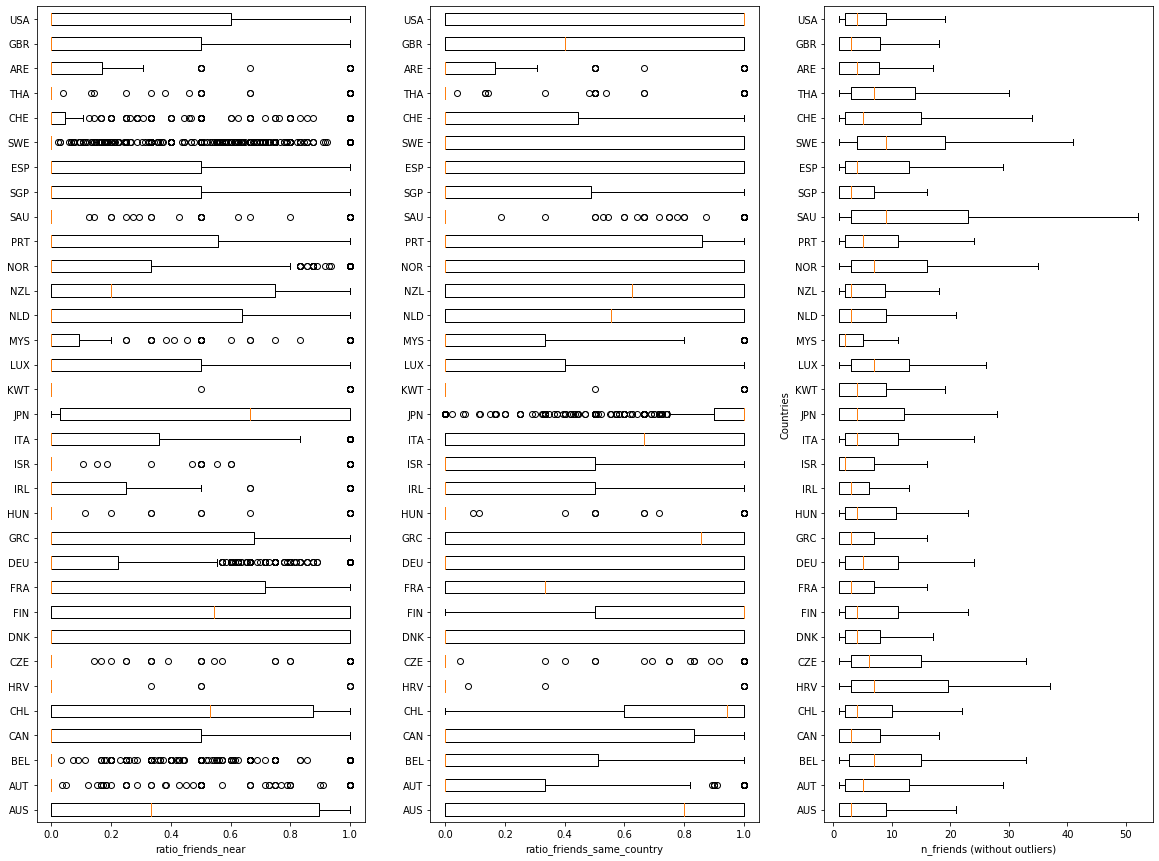

In [55]:
temp = users_all
features = ["ratio_friends_near","ratio_friends_same_country", "n_friends"]

fig, axs = plt.subplots(1, 3, figsize =(20,15))

for i, feature in enumerate(features):
    data = []
    for alpha3 in valid_countries_alpha3:
        users = temp[temp.alpha3 == alpha3]
        data.append(users[feature])
    if i == 2:
        #Impossible to see plots with outliers
        axs[i].boxplot(data,vert=False,showfliers=False)
        axs[i].set_xlabel(feature+" (without outliers)")
    else:
        axs[i].boxplot(data,vert=False,showfliers=True)
        axs[i].set_xlabel(feature)
    axs[i].set_yticks(np.arange(1,len(valid_countries_alpha3)+1))
    axs[i].set_yticklabels(valid_countries_alpha3)
    plt.ylabel("Countries")
plt.show()

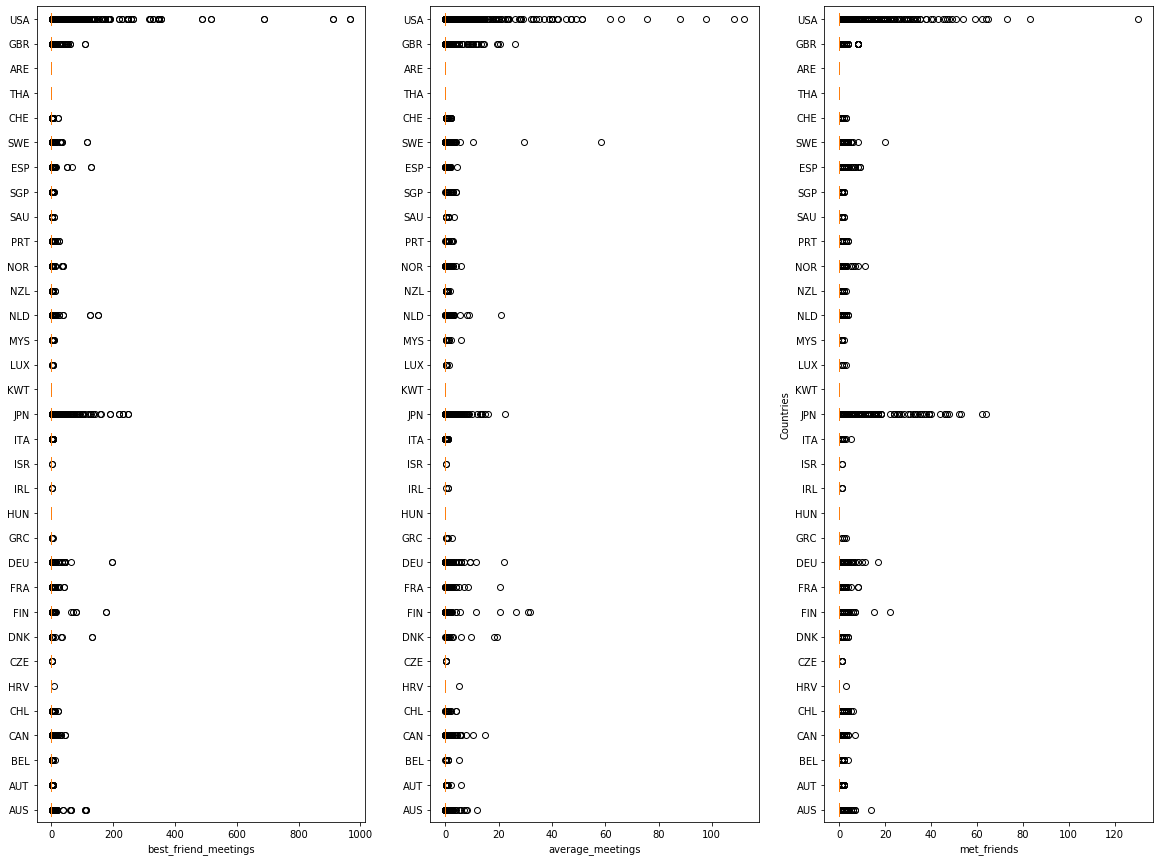

In [56]:
temp = users_all
features = ["best_friend_meetings","average_meetings","met_friends"]

fig, axs = plt.subplots(1, 3, figsize =(20,15))

for i, feature in enumerate(features):
    data = []
    for alpha3 in valid_countries_alpha3:
        users = temp[temp.alpha3 == alpha3]
        data.append(users[feature])
    #Impossible to see plots with outliers
    axs[i].boxplot(data,vert=False,showfliers=True)
    axs[i].set_yticks(np.arange(1,len(valid_countries_alpha3)+1))
    axs[i].set_yticklabels(valid_countries_alpha3)
    axs[i].set_xlabel(feature)
    plt.ylabel("Countries")
plt.show()


#### 3.4.2 Compare the mean of each country

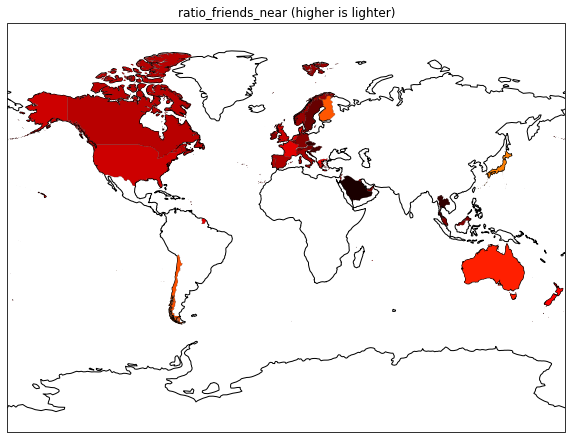

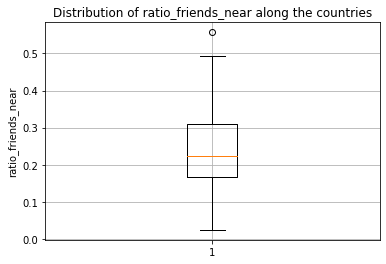

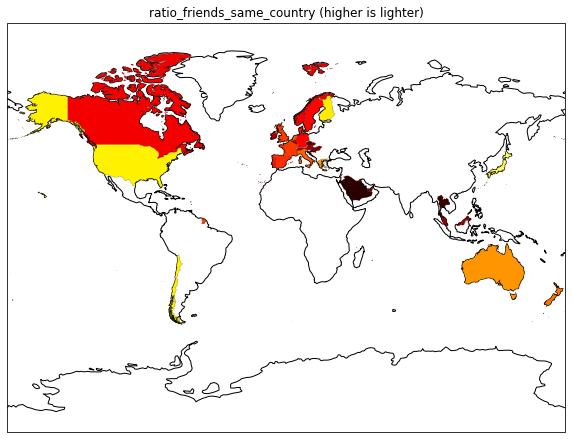

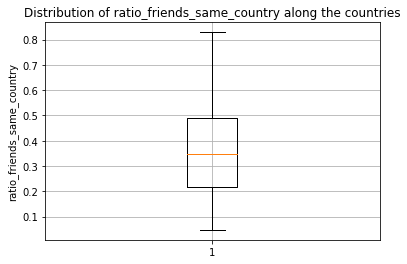

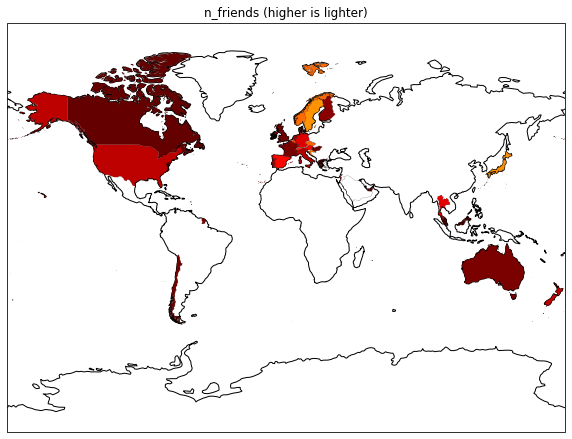

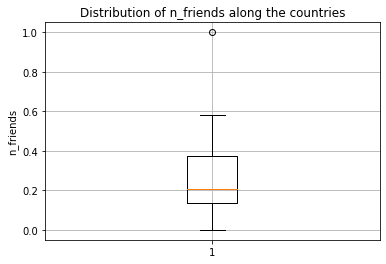

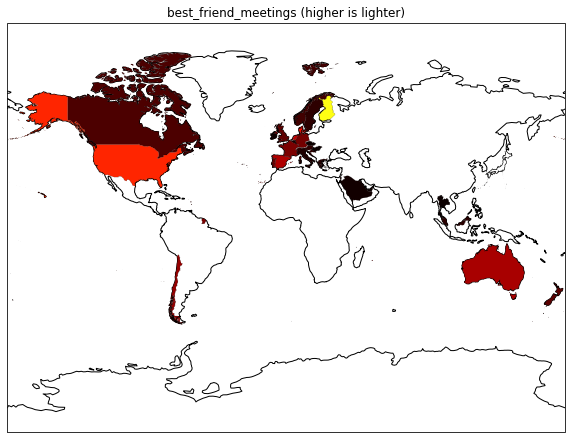

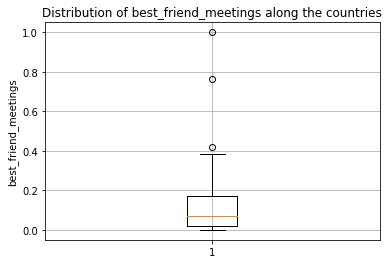

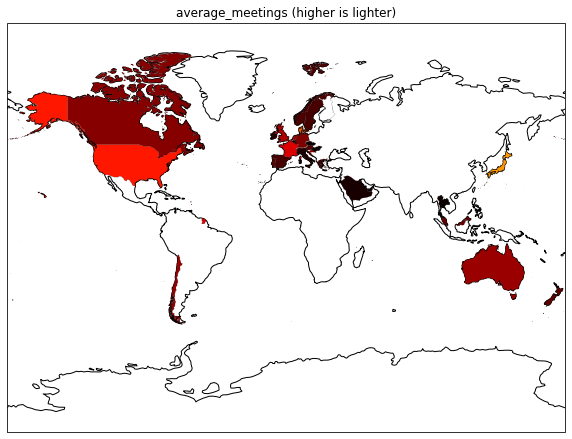

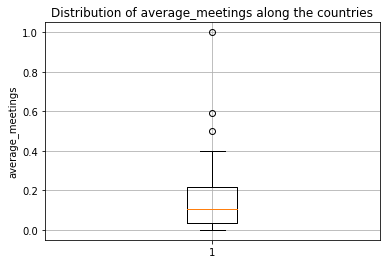

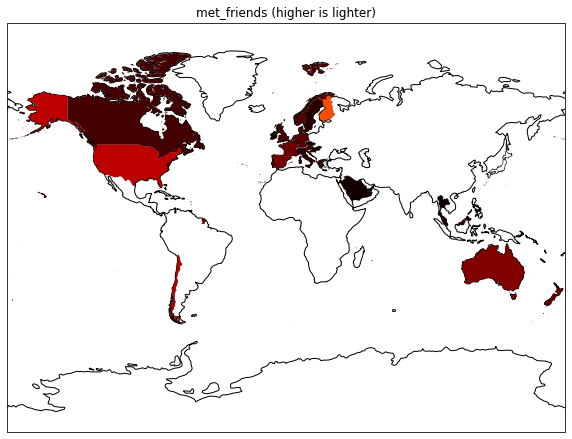

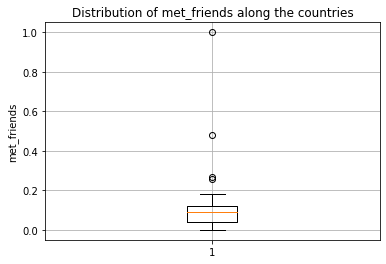

In [57]:
#Min max the value to be printable
temp = countries_friendships_0_1.copy()

features = ["ratio_friends_near","ratio_friends_same_country", "n_friends","best_friend_meetings","average_meetings","met_friends"]

for feature in features:
    #Create the world for the plot
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.Miller())
    ax.add_feature(cfeature.COASTLINE)

    #Plot all countries
    for i in range(0, temp.shape[0]) :
        color = cm.hot(temp.iloc[i][feature])
        area(ax, temp.iloc[i].alpha3, color)

    plt.title(feature+" (higher is lighter)")
    plt.show()
    
    plt.grid()
    plt.boxplot(temp[feature])
    plt.ylabel(feature)
    plt.title("Distribution of "+feature+" along the countries")
    plt.show()

### 3.5 Cluster the friendship informations

In [58]:
#Save id of countries
f_countries_alpha3 =  countries_friendships_std.alpha3

#Remove useless information
countries_friendships = countries_friendships_std.drop(columns = ["alpha3"])

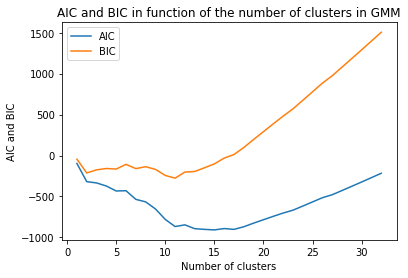

In [59]:
#Initialize the variables
all_aic = []
all_bic = []
NB_MAX_CENTROIDS = countries_friendships.shape[0]

#Evaluate the root mean square (RMS) with different values of k
for nb_centroids in range(1, NB_MAX_CENTROIDS):
    gmm = GaussianMixture(n_components=nb_centroids, n_init = 50, init_params = "kmeans").fit(countries_friendships)
    all_aic.append(gmm.aic(countries_friendships))
    all_bic.append(gmm.bic(countries_friendships))
    
    
#Plot the result
plt.plot(np.arange(1,NB_MAX_CENTROIDS), all_aic, label = "AIC")
plt.plot(np.arange(1,NB_MAX_CENTROIDS), all_bic, label = "BIC")
plt.title("AIC and BIC in function of the number of clusters in GMM")
plt.xlabel("Number of clusters")
plt.ylabel("AIC and BIC")
plt.legend()

The minimum for both metrics is around 14 clusters. That means that the friendships charachteristics are really different from a country to another and that only of few of them can be related.

In [60]:
#Compute with our best resut
BEST_NB_CLUSTERS = 14
gmm = GaussianMixture(n_components=BEST_NB_CLUSTERS, n_init = 100)
labels = gmm.fit_predict(countries_friendships)
res = pd.DataFrame(index = f_countries_alpha3, data = labels, columns =["labels"])

#Print the countries in each cluster
for lab in np.unique(labels):
    print("Label n°"+str(lab))
    print(res[res.labels == lab].index.values)
    
f_friendships_clusters = res

Label n°0
['ARE' 'HUN' 'ISR' 'KWT']
Label n°1
['USA']
Label n°2
['HRV' 'NOR' 'SWE']
Label n°3
['JPN']
Label n°4
['FIN']
Label n°5
['CAN' 'FRA' 'GBR' 'SGP']
Label n°6
['SAU']
Label n°7
['DEU' 'ESP' 'NZL' 'PRT']
Label n°8
['AUT' 'CHE' 'LUX']
Label n°9
['DNK']
Label n°10
['GRC' 'IRL' 'MYS']
Label n°11
['AUS' 'CHL' 'NLD']
Label n°12
['BEL' 'CZE']
Label n°13
['ITA' 'THA']


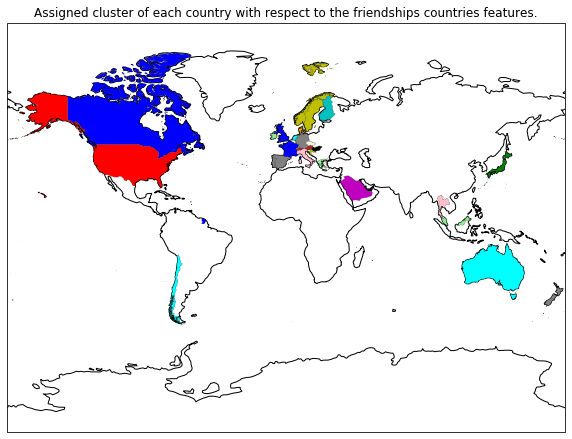

In [61]:
#Create the world for the plot
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.Miller())
ax.add_feature(cfeature.COASTLINE)

#Extract the clusters
clusters = np.unique(labels)
nb_cluster = np.max(clusters)

#Plot
if(nb_cluster > NB_MAX_GRP): #Some clusters cannot be plotted
    print("COLORS ARE REPEATING")
else:
    for i in range(0, len(labels)) :
        label = labels[i]
        color = color_names[label]
        area(ax, f_countries_alpha3.iloc[i], color)

    plt.title("Assigned cluster of each country with respect to the friendships countries features.")

### 3.6 Verify the statistical difference
Only on the valid countries

#### 3.5.1 Anova test 
Standard ANOVA takes as null hypothesis that all the groups distribution are the same. We assume normal distribution and independence.

In [62]:
features = ["ratio_friends_near","ratio_friends_same_country","n_friends","best_friend_meetings","average_meetings","met_friends"]

temp = users_all.copy()
temp.alpha3 = temp.alpha3.astype(str)
temp = temp[temp['alpha3'].isin(valid_countries_alpha3)]


for feature in features:
    print("\nFeature: "+feature+":")
    res = stat()
    res.anova_stat(df=temp, res_var=feature, anova_model=feature+' ~ C(alpha3)')
    print(res.anova_summary)


Feature: ratio_friends_near:
                df        sum_sq    mean_sq           F  PR(>F)
C(alpha3)     32.0    596.675263  18.646102  126.126933     0.0
Residual   84850.0  12543.885096   0.147836         NaN     NaN

Feature: ratio_friends_same_country:
                df        sum_sq    mean_sq           F  PR(>F)
C(alpha3)     32.0   2788.982924  87.155716  473.577264     0.0
Residual   84850.0  15615.535420   0.184037         NaN     NaN

Feature: n_friends:
                df        sum_sq       mean_sq         F        PR(>F)
C(alpha3)     32.0  4.783371e+05  14948.035101  6.462765  1.999603e-27
Residual   84850.0  1.962536e+08   2312.947242       NaN           NaN

Feature: best_friend_meetings:
                df        sum_sq     mean_sq         F        PR(>F)
C(alpha3)     32.0  2.712608e+04  847.690043  6.404118  4.455522e-27
Residual   84850.0  1.123129e+07  132.366408       NaN           NaN

Feature: average_meetings:
                df         sum_sq   mean_sq    

Not really normal

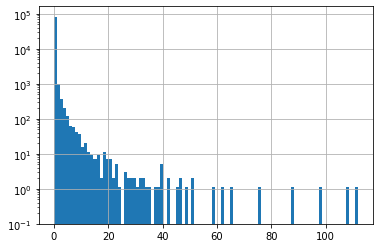

In [63]:
temp = users_all.copy()
temp.alpha3 = temp.alpha3.astype(str)
temp = temp[temp['alpha3'].isin(valid_countries_alpha3)]


series = temp.average_meetings
fig, ax = plt.subplots()
series.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')

#### 3.5.2 Kruskal-Wallis test
The normal distribution is maybe a too strong assumption for our data, so we do the same but with the Kruskal-Wallis test that assume less than ANVOVA. In this case the null hypothesis is that the median is the same for all.

In [64]:
features = ["ratio_friends_near","ratio_friends_same_country","n_friends","best_friend_meetings","average_meetings","met_friends"]

temp_dataset = users_all.copy()
temp_dataset.alpha3 = temp_dataset.alpha3.astype(str)
temp = temp[temp['alpha3'].isin(valid_countries_alpha3)]

for feature in features:    
    print("\nFeature: "+feature+":")
    temp = []
    alpha3s = temp_dataset.alpha3.unique()
    for alpha3 in alpha3s:
        temp.append(temp_dataset[temp_dataset.alpha3 == alpha3][feature])
    print(stats.kruskal(temp[0], temp[1],temp[2],temp[3],temp[4],temp[5],temp[6],temp[7],temp[8],temp[9],temp[10],temp[11],temp[12],temp[13],temp[14],temp[15],temp[16],temp[17],temp[18],temp[19],temp[20],temp[21],temp[22],temp[23],temp[24],temp[25],temp[26],temp[27]))


Feature: ratio_friends_near:
KruskalResult(statistic=3431.921659444486, pvalue=0.0)

Feature: ratio_friends_same_country:
KruskalResult(statistic=9027.350759406874, pvalue=0.0)

Feature: n_friends:
KruskalResult(statistic=2401.0210162068274, pvalue=0.0)

Feature: best_friend_meetings:
KruskalResult(statistic=1053.4007955395373, pvalue=1.1317388906063285e-204)

Feature: average_meetings:
KruskalResult(statistic=1018.2630961921163, pvalue=3.162228391435576e-197)

Feature: met_friends:
KruskalResult(statistic=1056.7972176110493, pvalue=2.156075688517917e-205)


Once more the features seems to be statistically different. And that maybe the last conclusion of ANOVA statitics was uncorrect due to the wrong hypotheses.

## 4. Analyze the data

### 4.0 Preprocess

Some of the features have an space that cannot be interpreted by the function because they have spaces in their names. A dictionary is created and applied to avoid this error:

In [65]:
countries_reg = countries_all_features.copy()

In [66]:
friendship_features_names = ["ratio_friends_near","ratio_friends_same_country","n_friends", "best_friend_meetings","average_meetings","met_friends"]

In [67]:
Features = ['Population_growth_rate','Urban_population_growth_rate','Population_density', 'Coastline', 'GPD_growth_rate']
for feature in Features:
    countries_reg[feature] = countries_reg[feature].astype(float)

### 4.1 Correlation matrix and pairplot

In [68]:
corr = countries_reg.corr()
corr = corr[friendship_features_names]
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,ratio_friends_near,ratio_friends_same_country,n_friends,best_friend_meetings,average_meetings,met_friends
best_friend_meetings,0.76,0.74,0.05,1.00,0.87,0.94
average_meetings,0.71,0.64,-0.11,0.87,1.00,0.73
met_friends,0.75,0.73,0.13,0.94,0.73,1.00
n_friends,-0.33,-0.20,1.00,0.05,-0.11,0.13
ratio_friends_same_country,0.90,1.00,-0.20,0.74,0.64,0.73
ratio_friends_near,1.00,0.90,-0.33,0.76,0.71,0.75
met_friends_ratio,0.76,0.65,-0.20,0.72,0.85,0.68
happiness_score,0.15,0.12,0.02,0.13,0.24,-0.03
social_support,0.18,0.16,0.04,0.22,0.30,0.08
freedom_of_choices,0.02,-0.15,0.02,0.12,0.23,0.01


Interesting points: (only consider > 0.5 correlation)

Correlations btw friendships charachs:
1. nb friends <-> total nb friends
2. best friend meeting  <->  total meeting  <-> met friends
3. met friends <-> total nb friends

Correlations with ratio_friends_near:
1. happiness_score (invers effect ? people are happy bcs friends are near)
2. perception_of_corruption (?)
3. GDP_per_capita (more urbanized)

Correlations with ratio_friends_same_country:
1. International_migrant_stock (people are not in the country)
2. Heath_total_expenditure (maybe influence migration)
3. Individuals_using_the_Internet (?)
4. Forested_area (? few friends near so more okay to find worlwide friends)

Correlations with total_nb_friends:
1. International_migrant_stock (?)
2. Forested_area (?)

Coorelations with all qualitatives -> DO NOT HAVE BIGGER THAN 50 -> quality does not change

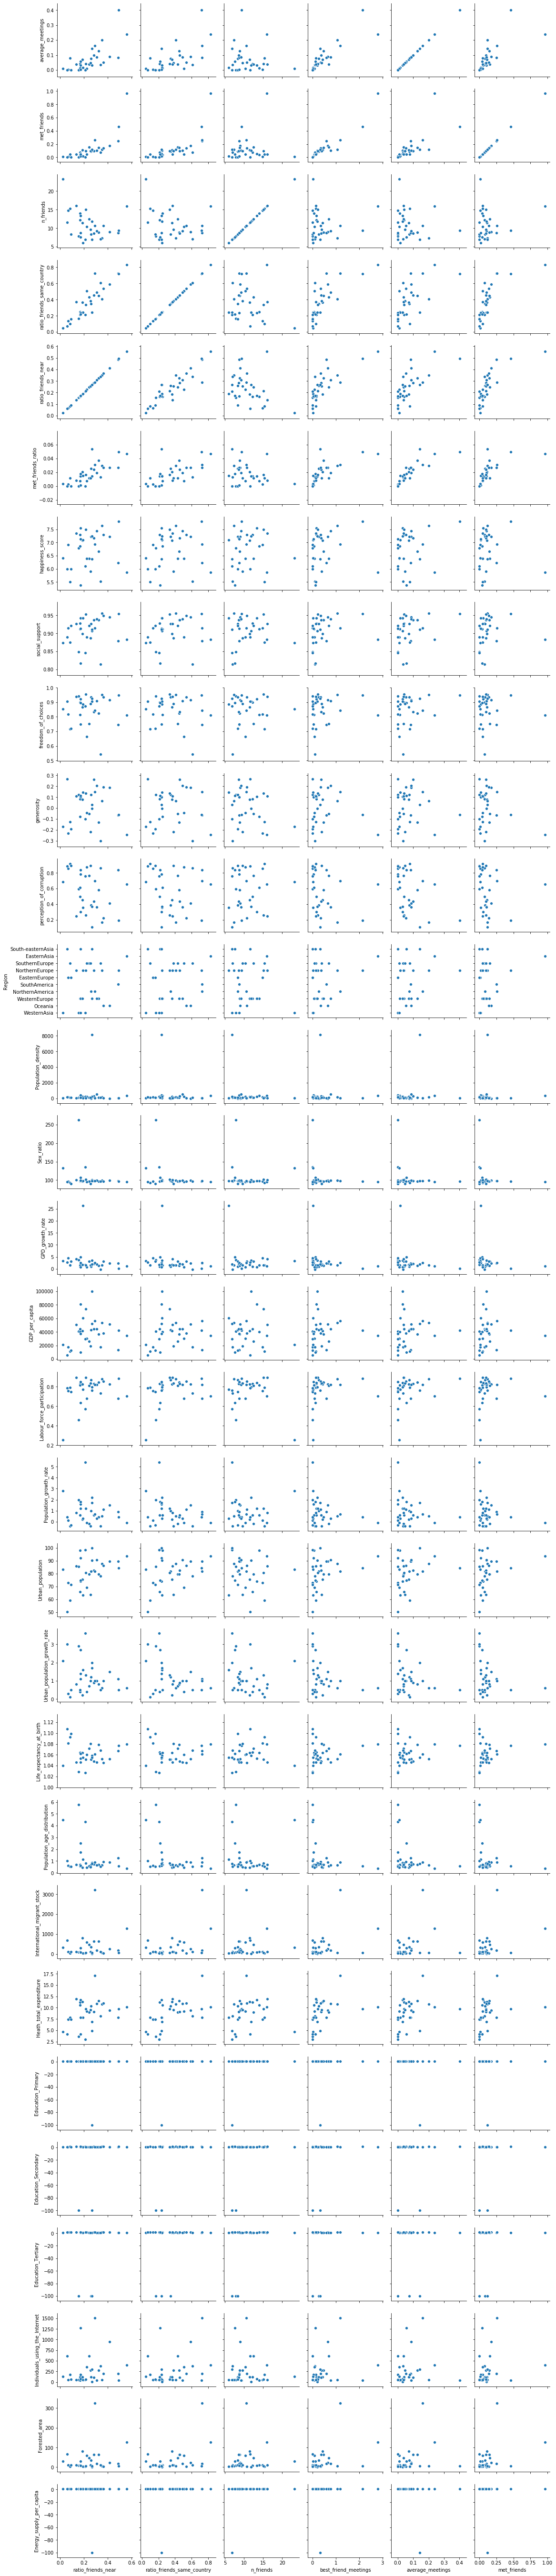

In [69]:
sns.pairplot(countries_reg,x_vars=friendship_features_names,
            y_vars = countries_reg.columns[2:-1])

Most of the plots seem to be random, although some seem to have a "tendency" like influence of near friends on happiness.

## 4.2 PCA

### 4.2.1 PCA on all

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [31] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [12] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


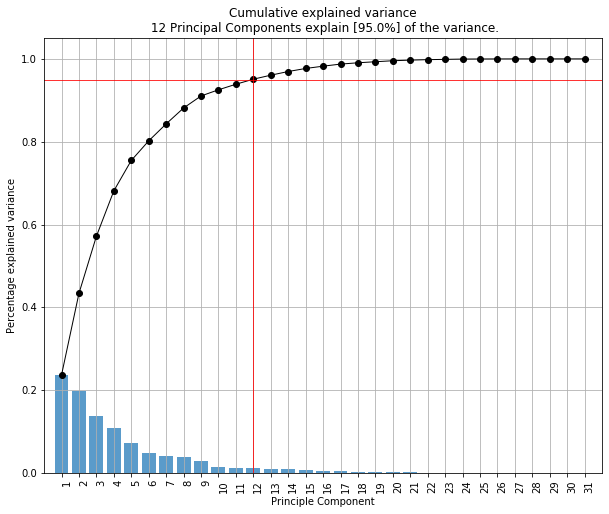

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2e0b8fb6b08>)

<Figure size 432x288 with 0 Axes>

In [70]:
# Initialize
model = pca()
df_temp = countries_all_features_std.drop(columns = ["Region","alpha3"])

# Fit transform
out = model.fit_transform(df_temp)

model.plot()

Looking at the cumulative variance we know that the 12th first PCA are significative. For each PC we will know compute what was the original variable that had the more influence.

In [71]:
# Print the top features. The results show that f1 is best, followed by f2 etc
print(out['topfeat'][:12])

      PC                         feature   loading  type
0    PC1         Heath_total_expenditure -0.290668  best
1    PC2        Energy_supply_per_capita -0.311565  best
2    PC3                 happiness_score -0.389422  best
3    PC4     Population_age_distribution -0.318075  best
4    PC5  Individuals_using_the_Internet  0.423807  best
5    PC6                       n_friends  0.687607  best
6    PC7                Urban_population -0.410725  best
7    PC8              Education_Tertiary -0.412575  best
8    PC9                 GPD_growth_rate  0.782717  best
9   PC10                       Coastline  0.555069  best
10  PC11                  GDP_per_capita  0.682357  best
11  PC12                average_meetings  0.439048  best


Interestingly we see that some friendship features appears. Especially ratio_friends_same_country  and average_meetings  which means they are a way (maybe indirect) to discriminate countries.

### 4.2.2 PCA to reduce countries features

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [25] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [11] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


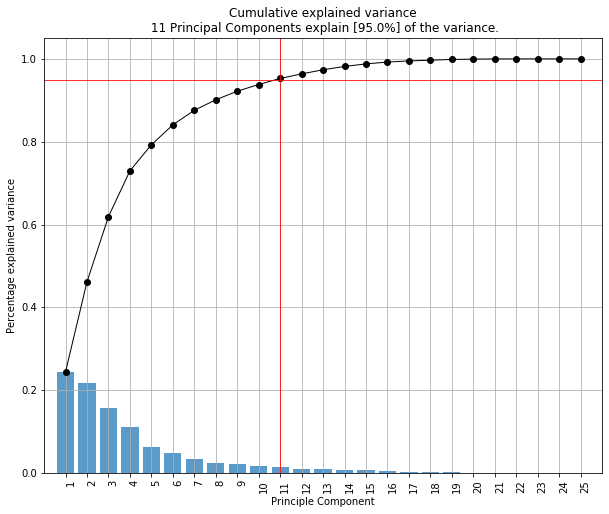

(<Figure size 720x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2e0b8fe7f48>)

<Figure size 432x288 with 0 Axes>

In [72]:
# Initialize
model = pca()
    
TO_REMOVE =  ["Region","alpha3"]+friendship_features_names
df_temp = countries_all_features_std.drop(columns =TO_REMOVE)
# Fit transform
out = model.fit_transform(df_temp)

model.plot()

Looking at the cumulative variance we know that the 10th first PCA are significative. For each PC we will know compute what was the original variable that had the more influence.

In [73]:
# Print the top features. The results show that f1 is best, followed by f2 etc
print(out['topfeat'][:10])

     PC              feature   loading  type
0   PC1  Education_Secondary -0.337674  best
1   PC2       social_support -0.355685  best
2   PC3    Education_Primary -0.309672  best
3   PC4        Forested_area  0.540600  best
4   PC5     Urban_population -0.540343  best
5   PC6            Sex_ratio  0.467945  best
6   PC7      GPD_growth_rate  0.759442  best
7   PC8    met_friends_ratio  0.599022  best
8   PC9            Coastline  0.422665  best
9  PC10       GDP_per_capita  0.651723  best


Usually, with PCA we take the PC as vector for the rest of the code. However here we need to keep a sense of meaning to our variables, so we will jsut extract the features that were the most important for each PC.

In [74]:
reduced_countries_features = out['topfeat']["feature"][:10].values

### 4.3 Regression on all
Need to see to which extent our previous conclusion are verified

#### 4.3.1 Happiness influenced by friendship charachteristics

In [75]:
mod = smf.ols(formula = 'happiness_score ~ ratio_friends_near + ratio_friends_same_country + n_friends', data = countries_all_features_std)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:        happiness_score   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                 -0.072
Method:                 Least Squares   F-statistic:                    0.2816
Date:                Fri, 18 Dec 2020   Prob (F-statistic):              0.838
Time:                        17:30:28   Log-Likelihood:                -46.351
No. Observations:                  33   AIC:                             100.7
Df Residuals:                      29   BIC:                             106.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

### 4.3.2 Friends near depending on all country features

In [76]:
FEATURES_REG = " ~ happiness_score + \
 social_support + freedom_of_choices + generosity + perception_of_corruption + \
 Population_density + Sex_ratio + GPD_growth_rate + GDP_per_capita + Labour_force_participation + \
 Population_growth_rate + Urban_population + Urban_population_growth_rate + Life_expectancy_at_birth + \
 Population_age_distribution + International_migrant_stock + Heath_total_expenditure + Education_Primary + \
 Education_Secondary + Education_Tertiary + Individuals_using_the_Internet + Forested_area + Energy_supply_per_capita + \
 Coastline"

In [77]:
mod = smf.ols(formula="ratio_friends_near"+FEATURES_REG , data=countries_all_features_std)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:     ratio_friends_near   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     2.353
Date:                Fri, 18 Dec 2020   Prob (F-statistic):              0.106
Time:                        17:30:28   Log-Likelihood:                -12.392
No. Observations:                  33   AIC:                             74.78
Df Residuals:                       8   BIC:                             112.2
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

We can say nothing about the results due to the p-values.

### 4.3.3 Friends in the same country depending on all country features

In [78]:
mod = smf.ols(formula='ratio_friends_same_country'+FEATURES_REG, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

                                OLS Regression Results                                
Dep. Variable:     ratio_friends_same_country   R-squared:                       0.909
Model:                                    OLS   Adj. R-squared:                  0.636
Method:                         Least Squares   F-statistic:                     3.328
Date:                        Fri, 18 Dec 2020   Prob (F-statistic):             0.0414
Time:                                17:30:28   Log-Likelihood:                -7.2847
No. Observations:                          33   AIC:                             64.57
Df Residuals:                               8   BIC:                             102.0
Df Model:                                  24                                         
Covariance Type:                    nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------

Forested area, population density, migrant stock and corruption seem to have an influence. With less certitude: appiness, labour force participation urban population and energy supply.

### 4.3.3 Total number of friends depending on all country features

In [79]:
mod = smf.ols(formula='n_friends'+FEATURES_REG, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              n_friends   R-squared:                       0.923
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     3.988
Date:                Fri, 18 Dec 2020   Prob (F-statistic):             0.0242
Time:                        17:30:28   Log-Likelihood:                -4.5475
No. Observations:                  33   AIC:                             59.10
Df Residuals:                       8   BIC:                             96.51
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

With low certitude: social support, generosity, corruption and sec ratio may have an influence.

### 4.3.4 Number of best friends meeting depending on all country features

In [80]:
mod = smf.ols(formula='best_friend_meetings'+FEATURES_REG, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

                             OLS Regression Results                             
Dep. Variable:     best_friend_meetings   R-squared:                       0.850
Model:                              OLS   Adj. R-squared:                  0.400
Method:                   Least Squares   F-statistic:                     1.887
Date:                  Fri, 18 Dec 2020   Prob (F-statistic):              0.178
Time:                          17:30:28   Log-Likelihood:                -15.533
No. Observations:                    33   AIC:                             81.07
Df Residuals:                         8   BIC:                             118.5
Df Model:                            24                                         
Covariance Type:              nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------

Nothing can be said, just that maybe population density has an influence.

### 4.3.5 Average meetings depending on all country features

In [81]:
mod = smf.ols(formula='average_meetings'+FEATURES_REG, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:       average_meetings   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.324
Method:                 Least Squares   F-statistic:                     1.640
Date:                Fri, 18 Dec 2020   Prob (F-statistic):              0.239
Time:                        17:30:28   Log-Likelihood:                -17.479
No. Observations:                  33   AIC:                             84.96
Df Residuals:                       8   BIC:                             122.4
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Nothing can be said, just maybe that age density and forested area may influence

### 4.3.6 Total number of meetings with friends depending on all country features

In [82]:
mod = smf.ols(formula='met_friends'+FEATURES_REG, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            met_friends   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     2.542
Date:                Fri, 18 Dec 2020   Prob (F-statistic):             0.0867
Time:                        17:30:28   Log-Likelihood:                -11.271
No. Observations:                  33   AIC:                             72.54
Df Residuals:                       8   BIC:                             110.0
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

Nothing can be said, just that maybe freedom of choices, generosity, population density and coastline may influence.

### 4.3.7 Regression conclusion
Few major elements -> maybe same everywhere. Non-lin regression doesn't seem necessary because the pairplot seem to show that it is random.

## 4.4 Regression on reduced dataset

### 4.4.1 Friends near depending on all country features

In [83]:
to_test = "ratio_friends_near"
txt = to_test+" ~ "
for i, feature in enumerate(reduced_countries_features):
    if(i != 0):
        txt+=" + "
    txt+=feature

print("Formula: "+txt)
    
mod = smf.ols(formula=txt, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

Formula: ratio_friends_near ~ Education_Secondary + social_support + Education_Primary + Forested_area + Urban_population + Sex_ratio + GPD_growth_rate + met_friends_ratio + Coastline + GDP_per_capita
                            OLS Regression Results                            
Dep. Variable:     ratio_friends_near   R-squared:                       0.834
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     11.08
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           1.83e-06
Time:                        17:30:29   Log-Likelihood:                -17.163
No. Observations:                  33   AIC:                             56.33
Df Residuals:                      22   BIC:                             72.79
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
         

GDP influences the nb of near friends. With less certitude does the forested areas.

### 4.4.2 Friends in the same country depending on all country features

In [84]:
to_test = "ratio_friends_same_country"
txt = to_test+" ~ "
for i, feature in enumerate(reduced_countries_features):
    if(i != 0):
        txt+=" + "
    txt+=feature

print("Formula: "+txt)
    
mod = smf.ols(formula=txt, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

Formula: ratio_friends_same_country ~ Education_Secondary + social_support + Education_Primary + Forested_area + Urban_population + Sex_ratio + GPD_growth_rate + met_friends_ratio + Coastline + GDP_per_capita
                                OLS Regression Results                                
Dep. Variable:     ratio_friends_same_country   R-squared:                       0.775
Model:                                    OLS   Adj. R-squared:                  0.673
Method:                         Least Squares   F-statistic:                     7.597
Date:                        Fri, 18 Dec 2020   Prob (F-statistic):           3.99e-05
Time:                                17:30:29   Log-Likelihood:                -22.180
No. Observations:                          33   AIC:                             66.36
Df Residuals:                              22   BIC:                             82.82
Df Model:                                  10                                         
Covarian

Now, only forested areas seem to have an influence on the friends in the same country.

### 4.4.3 Total number of friends depending on all country features

In [85]:
to_test = "n_friends"
txt = to_test+" ~ "
for i, feature in enumerate(reduced_countries_features):
    if(i != 0):
        txt+=" + "
    txt+=feature

print("Formula: "+txt)
    
mod = smf.ols(formula=txt, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

Formula: n_friends ~ Education_Secondary + social_support + Education_Primary + Forested_area + Urban_population + Sex_ratio + GPD_growth_rate + met_friends_ratio + Coastline + GDP_per_capita
                            OLS Regression Results                            
Dep. Variable:              n_friends   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                 -0.116
Method:                 Least Squares   F-statistic:                    0.6674
Date:                Fri, 18 Dec 2020   Prob (F-statistic):              0.742
Time:                        17:30:29   Log-Likelihood:                -42.453
No. Observations:                  33   AIC:                             106.9
Df Residuals:                      22   BIC:                             123.4
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  

Forested areas and gdp per capita

### 4.4.4 Number of best friends meeting depending on all country features

In [86]:
to_test = "best_friend_meetings"
txt = to_test+" ~ "
for i, feature in enumerate(reduced_countries_features):
    if(i != 0):
        txt+=" + "
    txt+=feature

print("Formula: "+txt)
    
mod = smf.ols(formula=txt, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

Formula: best_friend_meetings ~ Education_Secondary + social_support + Education_Primary + Forested_area + Urban_population + Sex_ratio + GPD_growth_rate + met_friends_ratio + Coastline + GDP_per_capita
                             OLS Regression Results                             
Dep. Variable:     best_friend_meetings   R-squared:                       0.734
Model:                              OLS   Adj. R-squared:                  0.613
Method:                   Least Squares   F-statistic:                     6.065
Date:                  Fri, 18 Dec 2020   Prob (F-statistic):           0.000213
Time:                          17:30:29   Log-Likelihood:                -24.986
No. Observations:                    33   AIC:                             71.97
Df Residuals:                        22   BIC:                             88.43
Df Model:                            10                                         
Covariance Type:              nonrobust                             

Nothing can be said, just that maybe population density has an influence.

### 4.4.5 Average meetings depending on all country features

In [87]:
to_test = "average_meetings"
txt = to_test+" ~ "
for i, feature in enumerate(reduced_countries_features):
    if(i != 0):
        txt+=" + "
    txt+=feature

print("Formula: "+txt)
    
mod = smf.ols(formula=txt, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

Formula: average_meetings ~ Education_Secondary + social_support + Education_Primary + Forested_area + Urban_population + Sex_ratio + GPD_growth_rate + met_friends_ratio + Coastline + GDP_per_capita
                            OLS Regression Results                            
Dep. Variable:       average_meetings   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     9.387
Date:                Fri, 18 Dec 2020   Prob (F-statistic):           7.36e-06
Time:                        17:30:29   Log-Likelihood:                -19.411
No. Observations:                  33   AIC:                             60.82
Df Residuals:                      22   BIC:                             77.28
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
           

GDP, maybe freedom

### 4.4.6 Total number of meetings with friends depending on all country features

In [88]:
to_test = "met_friends"
txt = to_test+" ~ "
for i, feature in enumerate(reduced_countries_features):
    if(i != 0):
        txt+=" + "
    txt+=feature

print("Formula: "+txt)
    
mod = smf.ols(formula=txt, data=countries_all_features_std)
res = mod.fit()
print(res.summary())

Formula: met_friends ~ Education_Secondary + social_support + Education_Primary + Forested_area + Urban_population + Sex_ratio + GPD_growth_rate + met_friends_ratio + Coastline + GDP_per_capita
                            OLS Regression Results                            
Dep. Variable:            met_friends   R-squared:                       0.669
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     4.444
Date:                Fri, 18 Dec 2020   Prob (F-statistic):            0.00170
Time:                        17:30:29   Log-Likelihood:                -28.589
No. Observations:                  33   AIC:                             79.18
Df Residuals:                      22   BIC:                             95.64
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                

freedom and gpd

### 4.4.7 Reduced Regression conclusion
Lot of information but some really certaind. Importance of GDP

## 5. Matching
For elements that seemed importants and make sens in the regression do matching to verify that it is right. Maybe use the cluster as a matching condition.

In [141]:
users_all_std = users_all.drop(columns = "alpha3")
for column in users_all.columns:
    if column != "alpha3":
        users_all_std[column] = scaler.fit_transform((users_all_std[column].values).reshape(-1,1))
        
users_all_std

,best_friend_meetings,average_meetings,met_friends,n_friends,n_friends_same_country,ratio_friends_same_country,n_friends_near,ratio_friends_near,met_friends_ratio
0,19.685541,4.364338,29.289356,2.293411,2.317930,0.531371,8.955039,0.682804,2.991941
1,5.874482,3.936906,13.010155,0.594741,0.687478,0.580730,3.138425,0.858731,4.157969
2,19.685541,2.809557,10.505662,1.486543,1.514872,0.511603,4.415243,0.329733,1.488074
3,4.320738,0.405275,9.879539,4.629083,4.654099,0.556039,8.103827,-0.051201,0.350451
4,0.867973,1.857015,9.253416,0.318708,0.006096,-0.791655,0.584790,-0.119553,4.470486
...,...,...,...,...,...,...,...,...,...
196514,-0.081537,-0.098557,-0.138431,-0.190893,-0.139915,-1.285714,-0.266422,-0.706523,-0.217264
196520,-0.081537,-0.098557,-0.138431,-0.190893,-0.139915,-1.285714,-0.266422,-0.706523,-0.217264
196531,-0.081537,-0.098557,-0.138431,-0.212127,-0.139915,-1.285714,-0.266422,-0.706523,-0.217264
196578,-0.081537,-0.098557,-0.138431,-0.105960,-0.139915,-1.285714,-0.266422,-0.706523,-0.217264


In [161]:
corr = users_all_std.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,best_friend_meetings,average_meetings,met_friends,n_friends,n_friends_same_country,ratio_friends_same_country,n_friends_near,ratio_friends_near,met_friends_ratio
best_friend_meetings,1.00,0.51,0.38,0.07,0.08,0.05,0.24,0.06,0.15
average_meetings,0.51,1.00,0.20,0.00,0.01,0.07,0.08,0.10,0.41
met_friends,0.38,0.20,1.00,0.16,0.18,0.09,0.57,0.11,0.28
n_friends,0.07,0.00,0.16,1.00,0.87,-0.04,0.21,-0.06,-0.01
n_friends_same_country,0.08,0.01,0.18,0.87,1.00,0.10,0.25,0.01,0.01
ratio_friends_same_country,0.05,0.07,0.09,-0.04,0.10,1.00,0.19,0.54,0.16
n_friends_near,0.24,0.08,0.57,0.21,0.25,0.19,1.00,0.27,0.09
ratio_friends_near,0.06,0.10,0.11,-0.06,0.01,0.54,0.27,1.00,0.24
met_friends_ratio,0.15,0.41,0.28,-0.01,0.01,0.16,0.09,0.24,1.00


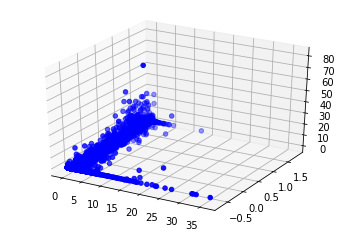

In [159]:
users_all_std_noout = users_all_std[users_all_std.n_friends <40]

y_vals = users_all_std_noout[["ratio_friends_near"]]
x_vals = users_all_std_noout[["n_friends"]]
z_vals = users_all_std_noout["met_friends"]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_vals, y_vals, z_vals, c = 'b', marker='o')

plt.show()

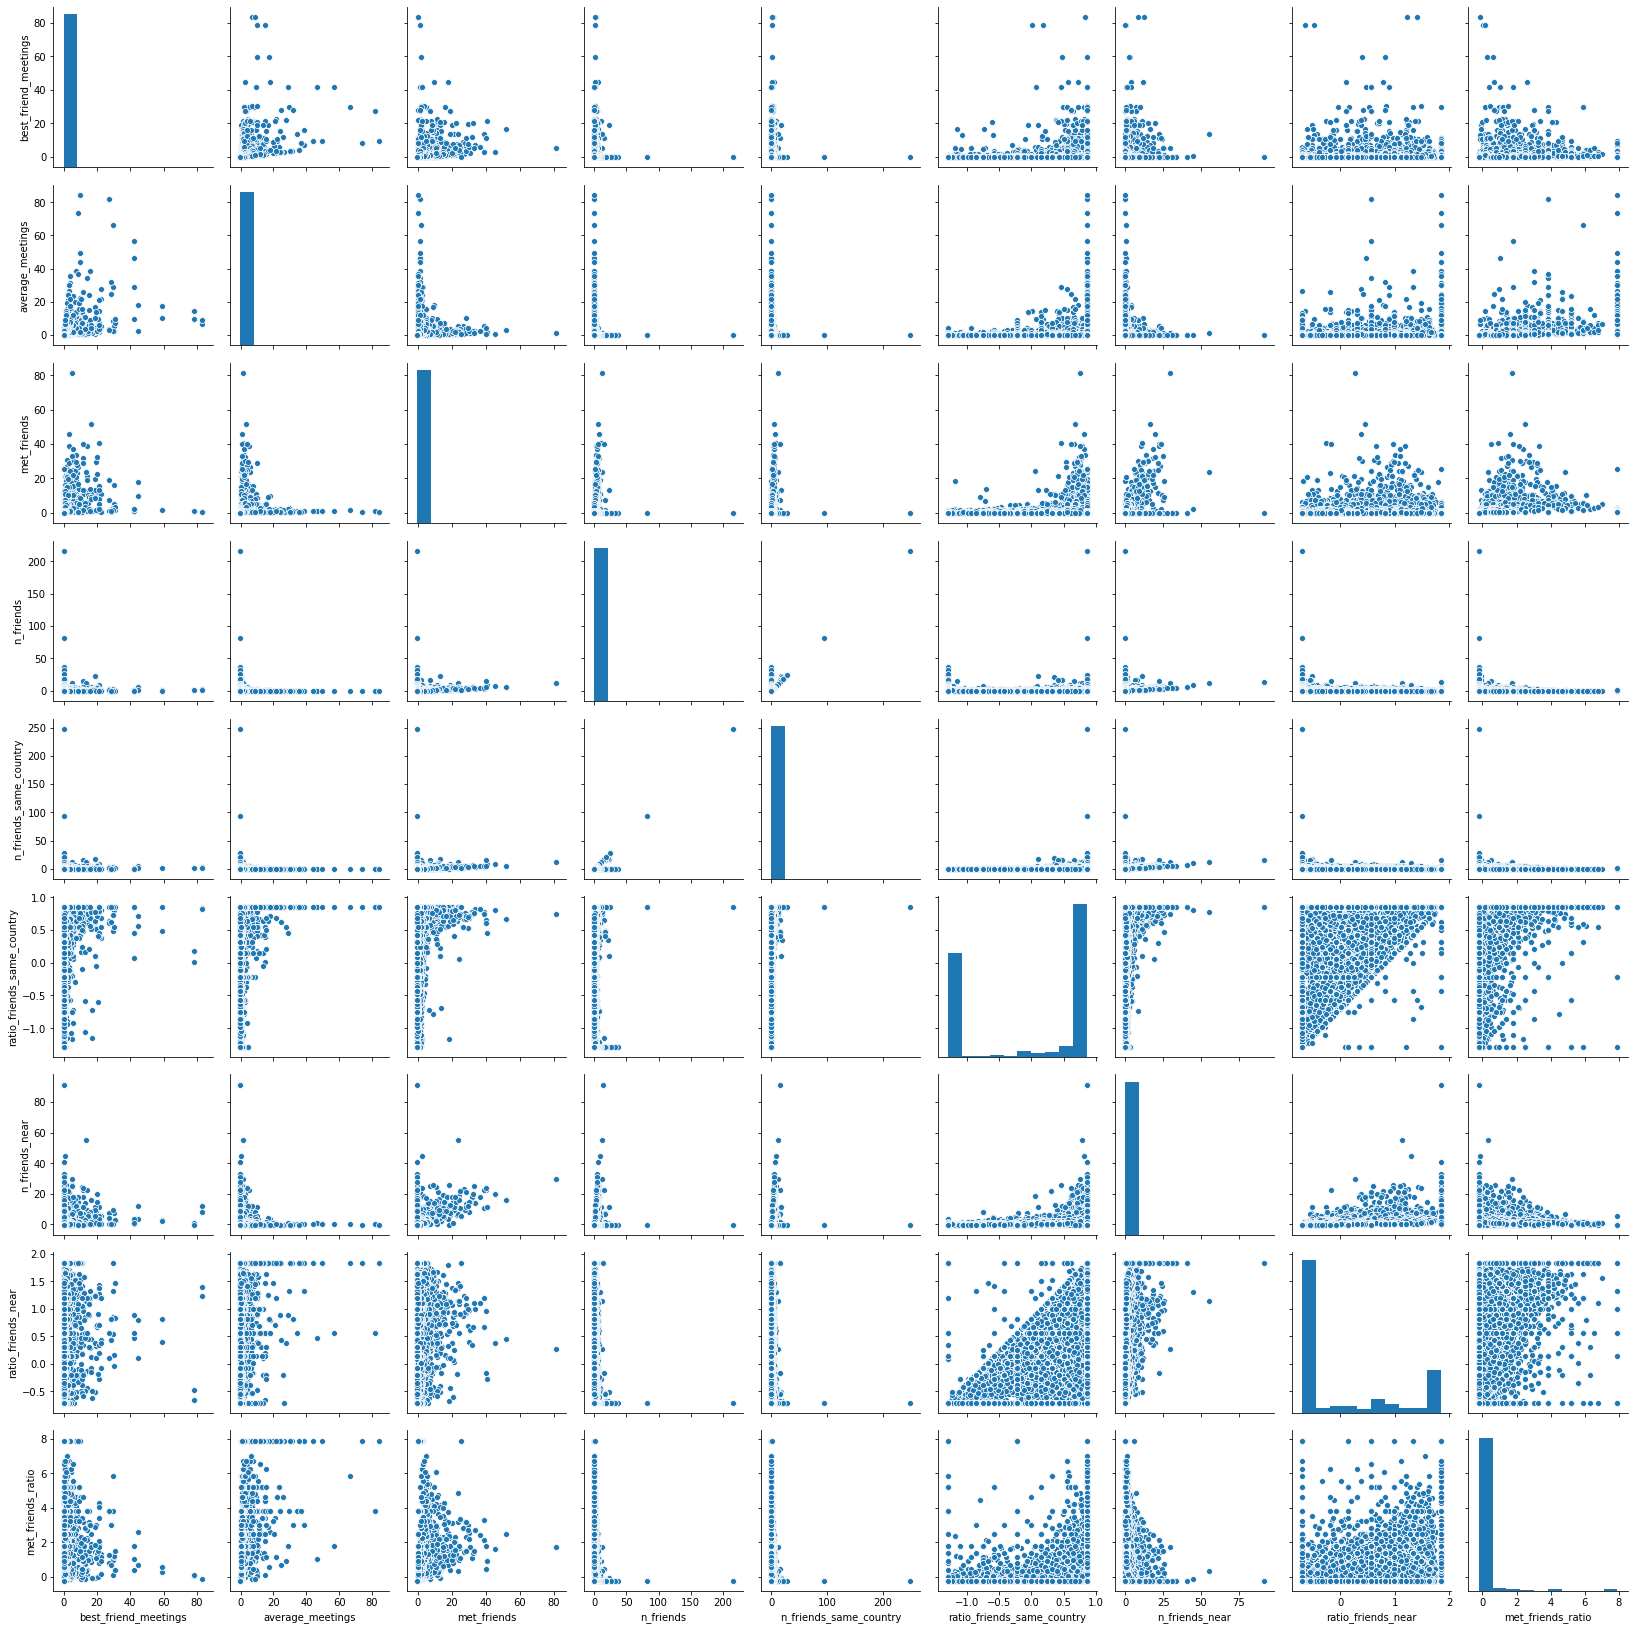

In [160]:
sns.pairplot(users_all_std)

In [172]:
quality_features = ["best_friend_meetings", "average_meetings", "met_friends", "met_friends_ratio"]
quantity_features = ["n_friends", "n_friends_same_country", "ratio_friends_same_country", "n_friends_near", \
                   "ratio_friends_near"]

In [175]:
to_test = "best_friend_meetings"
txt = to_test+" ~ "
for i, feature in enumerate(quantity_features+["met_friends"]):
    if(i != 0):
        txt+=" + "
    txt+=feature

print("Formula: "+txt)


mod = smf.ols(formula=txt, data=users_all_std)
res = mod.fit()
print(res.summary())

Formula: best_friend_meetings ~ n_friends + n_friends_same_country + ratio_friends_same_country + n_friends_near + ratio_friends_near + met_friends
                             OLS Regression Results                             
Dep. Variable:     best_friend_meetings   R-squared:                       0.144
Model:                              OLS   Adj. R-squared:                  0.144
Method:                   Least Squares   F-statistic:                     2489.
Date:                  Fri, 18 Dec 2020   Prob (F-statistic):               0.00
Time:                          19:01:16   Log-Likelihood:            -1.1948e+05
No. Observations:                 89067   AIC:                         2.390e+05
Df Residuals:                     89060   BIC:                         2.390e+05
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                                 coef    s

In [173]:
for quality in quality_features:
    to_test = quality
    txt = to_test+" ~ "
    for i, feature in enumerate(quantity_features):
        if(i != 0):
            txt+=" + "
        txt+=feature

    print("Formula: "+txt)


    mod = smf.ols(formula=txt, data=users_all_std)
    res = mod.fit()
    print(res.summary())

Formula: best_friend_meetings ~ n_friends + n_friends_same_country + ratio_friends_same_country + n_friends_near + ratio_friends_near
                             OLS Regression Results                             
Dep. Variable:     best_friend_meetings   R-squared:                       0.058
Model:                              OLS   Adj. R-squared:                  0.058
Method:                   Least Squares   F-statistic:                     1106.
Date:                  Fri, 18 Dec 2020   Prob (F-statistic):               0.00
Time:                          18:57:59   Log-Likelihood:            -1.2370e+05
No. Observations:                 89067   AIC:                         2.474e+05
Df Residuals:                     89061   BIC:                         2.475e+05
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                                 coef    std err        

## HAPPINESS

In [190]:
corr = countries_all_features[friendship_features_names +  ["happiness_score"]].corr()
corr = corr[["happiness_score"]]
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,happiness_score
ratio_friends_near,0.15
ratio_friends_same_country,0.12
n_friends,0.02
best_friend_meetings,0.13
average_meetings,0.24
met_friends,-0.03
happiness_score,1.00


The strongest correlation is with the average of meetings

In [193]:
to_test = "happiness_score"
txt = to_test+" ~ "
for i, feature in enumerate(friendship_features_names):
    if(i != 0):
        txt+=" + "
    txt+=feature

print("Formula: "+txt)


mod = smf.ols(formula=txt, data=countries_all_features)
res = mod.fit()
print(res.summary())

Formula: happiness_score ~ ratio_friends_near + ratio_friends_same_country + n_friends + best_friend_meetings + average_meetings + met_friends
                            OLS Regression Results                            
Dep. Variable:        happiness_score   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.147
Method:                 Least Squares   F-statistic:                     1.921
Date:                Fri, 18 Dec 2020   Prob (F-statistic):              0.115
Time:                        21:47:43   Log-Likelihood:                -27.351
No. Observations:                  33   AIC:                             68.70
Df Residuals:                      26   BIC:                             79.18
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>

We cannot extract any conclusion from this. Maybe if we had the happiness score of each user we could use the DataFrame "users_all_std" to see if there is any relation between frienship quality and quantity and happiness. We hypothesis that there is and that with a larger and more precise data it could be proved. Meanwhile we still enjoy our friends knowing that we are creating happiness together.